In [ ]:
!pip install matplotlib

     |████▋                           | 1.6 MB 15.7 MB/s eta 0:00:01

     |███████████████                 | 5.3 MB 15.7 MB/s eta 0:00:01

     |██████████████████████████▏     | 9.2 MB 15.7 MB/s eta 0:00:01

     |████████████████████████████████| 11.3 MB 15.7 MB/s eta 0:00:01

     |████████████████████████████████| 11.3 MB 15.7 MB/s 


     |███████████████████████▉        | 665 kB 77.3 MB/s eta 0:00:01

     |████████████████████████████████| 895 kB 77.3 MB/s 


     |█████████████████████           | 2.8 MB 68.5 MB/s eta 0:00:01

     |████████████████████████████████| 4.3 MB 68.5 MB/s 


     |███████████████████             | 696 kB 64.0 MB/s eta 0:00:01

     |████████████████████████████████| 1.2 MB 64.0 MB/s 


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
class MinibatchDiscriminator(tf.keras.layers.Layer):
    def __init__(self, b, c):
        super(MinibatchDiscriminator, self).__init__()
        self.b = b
        self.c = c

    def build(self, input_shape):
        self.T = self.add_weight("main_tensor",
            shape=(input_shape[-1], self.b, self.c),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
        )
    
    @tf.function
    def call(self, inputs):
        M = tf.tensordot(inputs, self.T, axes=[[1],[0]])
        diff = tf.expand_dims(M,0) - tf.expand_dims(M,1)
        c = tf.math.exp(-tf.norm(diff, ord=1, axis=3))
        o = tf.reduce_sum(c, axis=1)
        return tf.concat([inputs, o], 1)

     

In [ ]:
class AAE:
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size, gen_coef):
        super(AAE, self).__init__()

        # Calculate the stride factor of downsampling
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        
        # Latent dimension
        self.latent_dim = latent_dim
        # Define the optimizers
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_coef * base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        # Define losses and accuracies
        self.mse = tf.keras.losses.MeanSquaredError()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        # Define the learning rates for cyclic learning rate (not used)
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.gen_coef = gen_coef
        
        # Encoder net
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units[0], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        # Decoder net
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=latent_dim),
            tf.keras.layers.Dense(dense_units[0], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/self.stride_reduction**2), activation='relu'),
            tf.keras.layers.Reshape((int(input_shape[0]/self.stride_reduction), int(input_shape[1]/self.stride_reduction), filters[3])),
            tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same'),
        ])
        
        # Discriminator
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(discriminator_units[0], activation='relu'),
            tf.keras.layers.Dense(discriminator_units[1], activation='relu'),
            tf.keras.layers.Dense(1),
        ])

        # Compile the models
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()
    
    # Encoding function
    @tf.function
    def encode(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean

    # Decoding function
    @tf.function
    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    # Save 10 reconstructions
    def save_10_reconstructions(self, X, epoch):
        fig, ax = plt.subplots(2,5,figsize=(15,5))
        images = X[:10,:,:,:].reshape((10,32,32,3))
        z = self.encode(images)
        image_reconstruction = self.decode(z, apply_sigmoid=True).numpy()
        for i in range(10):
            ax.ravel()[i].imshow(image_reconstruction[i,:])
            ax.ravel()[i].axis(False)
        fig.savefig(f'reconstructed_epoch_{epoch+1:03d}.png',bbox_inches='tight')

    # Calculate autoencoder loss
    @tf.function
    def autoencoder_loss(self, X, training=False):
        # Encode and reconstruct
        z_generated = self.encode(X, training=training)
        X_generated = self.decode(z_generated, apply_sigmoid=True, training=training)
        # Autoencoder loss
        ae_loss = self.mse(X, X_generated)
        return ae_loss
    
    # Calculate generator loss
    @tf.function
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    # Calculate discriminator loss
    @tf.function
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    # Function for the train step
    @tf.function
    def train_step(self, batch_x):
        # Autoencoder training
        with tf.GradientTape() as ae_tape:
            ae_loss = self.autoencoder_loss(batch_x, training=True)

        # Apply the gradients
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        # Discriminator training with normal prior
        generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)

            dc_loss = self.discriminator_loss(dc_real, dc_fake)
            dc_acc = self.dc_accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        # Apply the gradients
        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator training (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            gen_loss = self.generator_loss(dc_fake)

        # Apply the gradients
        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        return ae_loss, dc_loss, dc_acc, gen_loss
    
    # Function 
    def fit(self, train_dataset, epochs, data_visual):
        # Save loss history
        ae_loss_history = []
        dc_loss_history = []
        gen_loss_history = []

        # Cyclic learning rate (not used)
        global_step = 0
        for epoch in range(epochs):
            # Learning rate reduction after epochs
            if epoch in [50, 100, 150, 200, 250]:
                self.base_lr = self.base_lr / 2
                self.max_lr = self.max_lr / 2
                self.step_size = self.step_size / 2

            # Save epoch time elapsed
            epoch_start = dt.now()
            for train_x in train_dataset:
                # Cyclic lr (not used)
            #    global_step = global_step + 1
            #    cycle = np.floor(1 + global_step / (2 * self.step_size))
            #    x_lr = np.abs(global_step / self.step_size - 2 * cycle + 1)
            #    clr = self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x_lr)

                # Update the learning rate
                self.ae_optimizer.learning_rate = self.base_lr
                self.dc_optimizer.learning_rate = self.gen_coef * self.base_lr
                self.gen_optimizer.learning_rate = self.base_lr
                # Train step and loss save
                ae_loss, dc_loss, dc_acc, gen_loss = self.train_step(train_x)
                ae_loss_history.append(ae_loss)
                dc_loss_history.append(dc_loss)
                gen_loss_history.append(gen_loss)
        
            epoch_end = dt.now()
            if epoch%10==0:
                self.save_10_reconstructions(data_visual, epoch)
            print("Epoch: {}, time elapsed: {}, AE loss: {}, Discriminator loss: {}, Discriminator accuracy: {}, Generator loss: {}".format(epoch + 1, epoch_end - epoch_start, ae_loss, dc_loss, dc_acc, gen_loss))    
        
        return ae_loss_history, dc_loss_history, gen_loss_history


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

    16384/170498071 [..............................] - ETA: 0s

    90112/170498071 [..............................] - ETA: 1:43

   434176/170498071 [..............................] - ETA: 43s 

  1777664/170498071 [..............................] - ETA: 15s

  6217728/170498071 [>.............................] - ETA: 5s 

 11182080/170498071 [>.............................] - ETA: 3s

 16408576/170498071 [=>............................] - ETA: 2s

 21291008/170498071 [==>...........................] - ETA: 2s

 26648576/170498071 [===>..........................] - ETA: 2s

 31891456/170498071 [====>.........................] - ETA: 2s

 37019648/170498071 [=====>........................] - ETA: 1s



 41967616/170498071 [======>.......................] - ETA: 1s



 47243264/170498071 [=======>......................] - ETA: 1s

 52436992/170498071 [========>.....................] - ETA: 1s



 57442304/170498071 [=========>....................] - ETA: 1s

 62775296/170498071 [==========>...................]

 - ETA: 1s

 67747840/170498071 [==========>...................]

 - ETA: 1s



 72982528/170498071 [===========>..................] - ETA: 1s

 78192640/170498071 [============>.................] - ETA: 1s



 83304448/170498071 [=============>................] - ETA: 1s



 88547328/170498071 [==============>...............] - ETA: 0s

 93356032/170498071 [===============>..............] - ETA: 0s



 98541568/170498071 [================>.............] - ETA: 0s

103817216/170498071 [=================>............] - ETA: 0s



108847104/170498071 [==================>...........] - ETA: 0s



114155520/170498071 [===================>..........] - ETA: 0s

119103488/170498071 [===================>..........] - ETA: 0s



124264448/170498071 [====================>.........] - ETA: 0s



129392640/170498071 [=====================>........]

 - ETA: 0s

134135808/170498071 [======================>.......]

 - ETA: 0s



139321344/170498071 [=======================>......] - ETA: 0s

144482304/170498071 [========================>.....] - ETA: 0s

149889024/170498071 [=========================>....] - ETA: 0s

155197440/170498071 [==========================>...] - ETA: 0s

160276480/170498071 [===========================>..] - ETA: 0s

165437440/170498071 [============================>.] - ETA: 0s

170500096/170498071 [==============================] - 2s 0us/step


170508288/170498071 [==============================] - 2s 0us/step


2022-02-20 10:51:21.987571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 10:51:22.000398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 10:51:22.001354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 10:51:22.003829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 10:51:22.004715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

2022-02-20 10:51:29.700197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-02-20 10:51:31.120770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


Epoch: 1, time elapsed: 0:01:01.208578, AE loss: 0.029611578211188316, Discriminator loss: 0.16709625720977783, Discriminator accuracy: 0.8120899796485901, Generator loss: 10.682065963745117


Epoch: 2, time elapsed: 0:00:52.095229, AE loss: 0.023733433336019516, Discriminator loss: 0.06682625412940979, Discriminator accuracy: 0.9005500078201294, Generator loss: 17.125797271728516


Epoch: 3, time elapsed: 0:00:51.775144, AE loss: 0.018418267369270325, Discriminator loss: 0.020545518025755882, Discriminator accuracy: 0.9321799874305725, Generator loss: 13.627912521362305


Epoch: 4, time elapsed: 0:01:22.562651, AE loss: 0.015525762923061848, Discriminator loss: 0.009820342995226383, Discriminator accuracy: 0.9487400054931641, Generator loss: 12.658639907836914


Epoch: 5, time elapsed: 0:00:51.755153, AE loss: 0.01510388869792223, Discriminator loss: 0.030965233221650124, Discriminator accuracy: 0.958791971206665, Generator loss: 14.296957015991211


Epoch: 6, time elapsed: 0:00:51.809821, AE loss: 0.013412520289421082, Discriminator loss: 0.021307893097400665, Discriminator accuracy: 0.9652299880981445, Generator loss: 17.571033477783203


Epoch: 7, time elapsed: 0:01:22.569014, AE loss: 0.011687705293297768, Discriminator loss: 0.03971417620778084, Discriminator accuracy: 0.9689871668815613, Generator loss: 22.95065689086914


Epoch: 8, time elapsed: 0:01:22.551769, AE loss: 0.010593528859317303, Discriminator loss: 0.008196313865482807, Discriminator accuracy: 0.971934974193573, Generator loss: 10.080816268920898


Epoch: 9, time elapsed: 0:00:51.861023, AE loss: 0.009100774303078651, Discriminator loss: 2.7696210963767953e-05, Discriminator accuracy: 0.9749744534492493, Generator loss: 4.394169330596924


Epoch: 10, time elapsed: 0:00:51.976288, AE loss: 0.008461689576506615, Discriminator loss: 0.003257333766669035, Discriminator accuracy: 0.9774100184440613, Generator loss: 2.1036863327026367


Epoch: 11, time elapsed: 0:00:51.991545, AE loss: 0.009249964728951454, Discriminator loss: 0.00023285979114007205, Discriminator accuracy: 0.9794390797615051, Generator loss: 2.678312301635742


Epoch: 12, time elapsed: 0:00:51.969489, AE loss: 0.008784373290836811, Discriminator loss: 0.0005204947083257139, Discriminator accuracy: 0.9811508059501648, Generator loss: 4.755144119262695


Epoch: 13, time elapsed: 0:00:51.968819, AE loss: 0.007367453072220087, Discriminator loss: 0.002685306593775749, Discriminator accuracy: 0.9825199842453003, Generator loss: 18.43142318725586


Epoch: 14, time elapsed: 0:00:52.010327, AE loss: 0.007258577737957239, Discriminator loss: 0.0041066850535571575, Discriminator accuracy: 0.9837528467178345, Generator loss: 6.715557098388672


Epoch: 15, time elapsed: 0:00:51.951370, AE loss: 0.006764187011867762, Discriminator loss: 2.8258932616154198e-06, Discriminator accuracy: 0.9847453236579895, Generator loss: 0.14215600490570068


Epoch: 16, time elapsed: 0:00:52.017808, AE loss: 0.007516908459365368, Discriminator loss: 0.0009150657569989562, Discriminator accuracy: 0.9855625033378601, Generator loss: 71.32862854003906


Epoch: 17, time elapsed: 0:00:51.987839, AE loss: 0.006606061942875385, Discriminator loss: 0.0010546991834416986, Discriminator accuracy: 0.9863694310188293, Generator loss: 60.210609436035156


Epoch: 18, time elapsed: 0:00:51.973073, AE loss: 0.006919580511748791, Discriminator loss: 3.0519736355927307e-06, Discriminator accuracy: 0.9870250225067139, Generator loss: 4.94245719909668


Epoch: 19, time elapsed: 0:00:52.004803, AE loss: 0.0066880760714411736, Discriminator loss: 0.005620713345706463, Discriminator accuracy: 0.987692654132843, Generator loss: 29.75921630859375


Epoch: 20, time elapsed: 0:00:52.014331, AE loss: 0.006937412079423666, Discriminator loss: 0.0022473742719739676, Discriminator accuracy: 0.9881899952888489, Generator loss: 52.32966232299805


Epoch: 21, time elapsed: 0:00:51.971051, AE loss: 0.0062039620243012905, Discriminator loss: 0.011840427294373512, Discriminator accuracy: 0.9886266589164734, Generator loss: 140.7135467529297


Epoch: 22, time elapsed: 0:00:51.983957, AE loss: 0.0060926806181669235, Discriminator loss: 6.397794641088694e-05, Discriminator accuracy: 0.9890918135643005, Generator loss: 3.168907642364502


Epoch: 23, time elapsed: 0:00:52.012476, AE loss: 0.006581065710633993, Discriminator loss: 0.00301063759252429, Discriminator accuracy: 0.9894895553588867, Generator loss: 57.26813507080078


Epoch: 24, time elapsed: 0:00:51.988791, AE loss: 0.0062124659307301044, Discriminator loss: 8.752115536481142e-05, Discriminator accuracy: 0.9898825287818909, Generator loss: 11.57307243347168


Epoch: 25, time elapsed: 0:00:52.001534, AE loss: 0.005553201772272587, Discriminator loss: 6.457662038883427e-06, Discriminator accuracy: 0.9902827739715576, Generator loss: 2.640641450881958


Epoch: 26, time elapsed: 0:00:51.997946, AE loss: 0.006091707851737738, Discriminator loss: 5.533138846658403e-06, Discriminator accuracy: 0.9906507730484009, Generator loss: 1.452091932296753


Epoch: 27, time elapsed: 0:01:22.582624, AE loss: 0.005913112312555313, Discriminator loss: 1.3923347978561651e-05, Discriminator accuracy: 0.9909899830818176, Generator loss: 0.8740105628967285


Epoch: 28, time elapsed: 0:00:51.895068, AE loss: 0.00521691981703043, Discriminator loss: 1.8578113667899743e-05, Discriminator accuracy: 0.991310715675354, Generator loss: 3.409214735031128


Epoch: 29, time elapsed: 0:00:51.921649, AE loss: 0.005227142479270697, Discriminator loss: 3.035552026631194e-06, Discriminator accuracy: 0.9916096329689026, Generator loss: 3.7825374603271484


Epoch: 30, time elapsed: 0:00:51.930721, AE loss: 0.00549838412553072, Discriminator loss: 0.000194374835700728, Discriminator accuracy: 0.9918886423110962, Generator loss: 37.60142135620117


Epoch: 31, time elapsed: 0:00:51.957352, AE loss: 0.0059507149271667, Discriminator loss: 0.028586292639374733, Discriminator accuracy: 0.9921132326126099, Generator loss: 52.13677978515625


Epoch: 32, time elapsed: 0:00:51.934854, AE loss: 0.00523028988391161, Discriminator loss: 0.0007232075440697372, Discriminator accuracy: 0.9923237562179565, Generator loss: 33.45705032348633


Epoch: 33, time elapsed: 0:01:22.634165, AE loss: 0.004883063491433859, Discriminator loss: 1.3382034012465738e-05, Discriminator accuracy: 0.9925506114959717, Generator loss: 10.81860637664795


Epoch: 34, time elapsed: 0:00:51.952036, AE loss: 0.004828160163015127, Discriminator loss: 2.4123000912368298e-06, Discriminator accuracy: 0.9927691221237183, Generator loss: 4.749582767486572


Epoch: 35, time elapsed: 0:00:51.970859, AE loss: 0.005354832857847214, Discriminator loss: 1.673995029705111e-05, Discriminator accuracy: 0.9929734468460083, Generator loss: 4.979340553283691


Epoch: 36, time elapsed: 0:01:22.606610, AE loss: 0.005444078240543604, Discriminator loss: 1.1390445706638275e-06, Discriminator accuracy: 0.9931663870811462, Generator loss: 1.0298031568527222


Epoch: 37, time elapsed: 0:00:52.005467, AE loss: 0.004646584391593933, Discriminator loss: 2.9598987794088316e-07, Discriminator accuracy: 0.9933502674102783, Generator loss: 1.0877816677093506


Epoch: 38, time elapsed: 0:00:52.027848, AE loss: 0.005118939094245434, Discriminator loss: 3.583615125535289e-06, Discriminator accuracy: 0.9935184121131897, Generator loss: 4.7593607902526855


Epoch: 39, time elapsed: 0:00:51.971114, AE loss: 0.004863573703914881, Discriminator loss: 5.403437171480618e-06, Discriminator accuracy: 0.9936830997467041, Generator loss: 4.58021879196167


Epoch: 40, time elapsed: 0:00:52.004122, AE loss: 0.004705045837908983, Discriminator loss: 5.4458264457935e-06, Discriminator accuracy: 0.9938349723815918, Generator loss: 0.36149081587791443


Epoch: 41, time elapsed: 0:00:52.007765, AE loss: 0.005563138518482447, Discriminator loss: 0.0008656204445287585, Discriminator accuracy: 0.9939839243888855, Generator loss: 0.4124528467655182


Epoch: 42, time elapsed: 0:00:51.989712, AE loss: 0.005199973937124014, Discriminator loss: 3.575197979444056e-06, Discriminator accuracy: 0.9941259622573853, Generator loss: 34.832740783691406


Epoch: 43, time elapsed: 0:00:52.034982, AE loss: 0.0046436721459031105, Discriminator loss: 4.721812001662329e-05, Discriminator accuracy: 0.9942602515220642, Generator loss: 15.152552604675293


Epoch: 44, time elapsed: 0:00:51.991793, AE loss: 0.00582451606169343, Discriminator loss: 1.4056665165185223e-08, Discriminator accuracy: 0.9943609237670898, Generator loss: 87.9080581665039


Epoch: 45, time elapsed: 0:00:51.958382, AE loss: 0.005124602001160383, Discriminator loss: 0.00016090726421680301, Discriminator accuracy: 0.9944444298744202, Generator loss: 22.834733963012695


Epoch: 46, time elapsed: 0:00:52.001391, AE loss: 0.00443730503320694, Discriminator loss: 0.004483007360249758, Discriminator accuracy: 0.994511067867279, Generator loss: 292.7112731933594


Epoch: 47, time elapsed: 0:00:51.990931, AE loss: 0.004515390843153, Discriminator loss: 0.00011630936205619946, Discriminator accuracy: 0.994547426700592, Generator loss: 64.69290924072266


Epoch: 48, time elapsed: 0:00:51.920997, AE loss: 0.004473404493182898, Discriminator loss: 1.2116039215470664e-05, Discriminator accuracy: 0.9946402311325073, Generator loss: 6.964766502380371


Epoch: 49, time elapsed: 0:00:51.989624, AE loss: 0.0048679327592253685, Discriminator loss: 3.4917302400572225e-06, Discriminator accuracy: 0.9946898221969604, Generator loss: 33.84589767456055


Epoch: 50, time elapsed: 0:00:52.006345, AE loss: 0.004255008418112993, Discriminator loss: 1.233441707881866e-06, Discriminator accuracy: 0.9947440028190613, Generator loss: 0.26658836007118225


Epoch: 51, time elapsed: 0:00:51.931300, AE loss: 0.004697734024375677, Discriminator loss: 3.3921726299013244e-06, Discriminator accuracy: 0.9948433041572571, Generator loss: 3.0203471183776855


Epoch: 52, time elapsed: 0:01:22.585687, AE loss: 0.0041739619337022305, Discriminator loss: 0.0034982527140527964, Discriminator accuracy: 0.9947848320007324, Generator loss: 50.2462043762207


Epoch: 53, time elapsed: 0:00:51.971414, AE loss: 0.004007359966635704, Discriminator loss: 6.904707788635278e-06, Discriminator accuracy: 0.9948248863220215, Generator loss: 6.273931503295898


Epoch: 54, time elapsed: 0:00:52.088354, AE loss: 0.003803431522101164, Discriminator loss: 0.06006862223148346, Discriminator accuracy: 0.9947418570518494, Generator loss: 55.93349075317383


Epoch: 55, time elapsed: 0:00:52.075264, AE loss: 0.004004530608654022, Discriminator loss: 0.0009230444557033479, Discriminator accuracy: 0.9944687485694885, Generator loss: 15.860513687133789


Epoch: 56, time elapsed: 0:00:52.070259, AE loss: 0.004064951092004776, Discriminator loss: 0.057575978338718414, Discriminator accuracy: 0.9939457178115845, Generator loss: 14.75727653503418


Epoch: 57, time elapsed: 0:00:51.986720, AE loss: 0.0043205032125115395, Discriminator loss: 0.20973512530326843, Discriminator accuracy: 0.9935452342033386, Generator loss: 10.32975959777832


Epoch: 58, time elapsed: 0:00:52.061796, AE loss: 0.004514156840741634, Discriminator loss: 0.007352037355303764, Discriminator accuracy: 0.9935474395751953, Generator loss: 5.870994567871094


Epoch: 59, time elapsed: 0:00:51.988940, AE loss: 0.004011174663901329, Discriminator loss: 0.02515985444188118, Discriminator accuracy: 0.993435263633728, Generator loss: 16.62202262878418


Epoch: 60, time elapsed: 0:00:52.040956, AE loss: 0.004350056406110525, Discriminator loss: 0.05568944290280342, Discriminator accuracy: 0.9933873414993286, Generator loss: 6.4680585861206055


Epoch: 61, time elapsed: 0:00:52.018622, AE loss: 0.0047020092606544495, Discriminator loss: 0.08570271730422974, Discriminator accuracy: 0.9931116104125977, Generator loss: 4.386270523071289


Epoch: 62, time elapsed: 0:00:51.991470, AE loss: 0.0037007462233304977, Discriminator loss: 0.24320201575756073, Discriminator accuracy: 0.992626428604126, Generator loss: 5.342396259307861


Epoch: 63, time elapsed: 0:00:51.989873, AE loss: 0.004412132315337658, Discriminator loss: 0.17402859032154083, Discriminator accuracy: 0.9919103384017944, Generator loss: 8.143138885498047


Epoch: 64, time elapsed: 0:01:22.570191, AE loss: 0.0035854135639965534, Discriminator loss: 0.6151096820831299, Discriminator accuracy: 0.9912202954292297, Generator loss: 9.731515884399414


Epoch: 65, time elapsed: 0:00:51.939976, AE loss: 0.004171872045844793, Discriminator loss: 0.5450881123542786, Discriminator accuracy: 0.9906094074249268, Generator loss: 9.833685874938965


Epoch: 66, time elapsed: 0:00:51.959666, AE loss: 0.005306419916450977, Discriminator loss: 0.30473968386650085, Discriminator accuracy: 0.989702582359314, Generator loss: 5.4884796142578125


Epoch: 67, time elapsed: 0:00:51.967853, AE loss: 0.003991330973803997, Discriminator loss: 0.36506742238998413, Discriminator accuracy: 0.9884783625602722, Generator loss: 6.219594478607178


Epoch: 68, time elapsed: 0:00:51.938414, AE loss: 0.0044356780126690865, Discriminator loss: 0.32263612747192383, Discriminator accuracy: 0.9871151447296143, Generator loss: 3.8514397144317627


Epoch: 69, time elapsed: 0:00:51.968702, AE loss: 0.00380310183390975, Discriminator loss: 0.4821748733520508, Discriminator accuracy: 0.9861181378364563, Generator loss: 9.538946151733398


Epoch: 70, time elapsed: 0:00:51.987050, AE loss: 0.0036825425922870636, Discriminator loss: 1.1286872625350952, Discriminator accuracy: 0.984943151473999, Generator loss: 6.123391151428223


Epoch: 71, time elapsed: 0:00:52.016857, AE loss: 0.0037476751022040844, Discriminator loss: 0.0849674716591835, Discriminator accuracy: 0.9841918349266052, Generator loss: 4.833836078643799


Epoch: 72, time elapsed: 0:00:52.015657, AE loss: 0.003949174657464027, Discriminator loss: 0.36475425958633423, Discriminator accuracy: 0.9838458299636841, Generator loss: 3.642575740814209


Epoch: 73, time elapsed: 0:00:52.101107, AE loss: 0.003807310713455081, Discriminator loss: 0.5060930252075195, Discriminator accuracy: 0.9829273819923401, Generator loss: 4.853672981262207


Epoch: 74, time elapsed: 0:00:51.959582, AE loss: 0.004165728576481342, Discriminator loss: 0.5939561724662781, Discriminator accuracy: 0.9819328188896179, Generator loss: 3.818350315093994


Epoch: 75, time elapsed: 0:01:22.582010, AE loss: 0.00385522423312068, Discriminator loss: 0.46009302139282227, Discriminator accuracy: 0.9803642630577087, Generator loss: 1.824053168296814


Epoch: 76, time elapsed: 0:00:51.977789, AE loss: 0.00385504262521863, Discriminator loss: 0.5128797292709351, Discriminator accuracy: 0.9790789484977722, Generator loss: 7.3777055740356445


Epoch: 77, time elapsed: 0:00:52.010047, AE loss: 0.00354745308868587, Discriminator loss: 0.4794042706489563, Discriminator accuracy: 0.9773204922676086, Generator loss: 2.6911306381225586


Epoch: 78, time elapsed: 0:00:52.046725, AE loss: 0.0038125410210341215, Discriminator loss: 0.706518828868866, Discriminator accuracy: 0.975699245929718, Generator loss: 4.1077094078063965


Epoch: 79, time elapsed: 0:00:52.027377, AE loss: 0.003894661320373416, Discriminator loss: 0.622285008430481, Discriminator accuracy: 0.9739546775817871, Generator loss: 1.672824501991272


Epoch: 80, time elapsed: 0:00:52.042522, AE loss: 0.004374534823000431, Discriminator loss: 0.254146546125412, Discriminator accuracy: 0.9733328819274902, Generator loss: 3.6114845275878906


Epoch: 81, time elapsed: 0:00:52.046901, AE loss: 0.003807166125625372, Discriminator loss: 0.6809089779853821, Discriminator accuracy: 0.9724955558776855, Generator loss: 2.1775405406951904


Epoch: 82, time elapsed: 0:01:22.609609, AE loss: 0.0036343869287520647, Discriminator loss: 0.09646186232566833, Discriminator accuracy: 0.9705678224563599, Generator loss: 0.5179814100265503


Epoch: 83, time elapsed: 0:00:51.967871, AE loss: 0.0043913451954722404, Discriminator loss: 0.5378482341766357, Discriminator accuracy: 0.9695637226104736, Generator loss: 2.0925707817077637


Epoch: 84, time elapsed: 0:00:52.003346, AE loss: 0.0033243573270738125, Discriminator loss: 0.5002228617668152, Discriminator accuracy: 0.968217134475708, Generator loss: 0.726459801197052


Epoch: 85, time elapsed: 0:01:22.581339, AE loss: 0.003534118877723813, Discriminator loss: 1.098412275314331, Discriminator accuracy: 0.9664755463600159, Generator loss: 1.6187124252319336


Epoch: 86, time elapsed: 0:00:51.897046, AE loss: 0.003456884529441595, Discriminator loss: 1.6829569339752197, Discriminator accuracy: 0.964714765548706, Generator loss: 0.7665820121765137


Epoch: 87, time elapsed: 0:00:51.936789, AE loss: 0.003780081169679761, Discriminator loss: 0.6371462345123291, Discriminator accuracy: 0.9623850584030151, Generator loss: 2.834381580352783


Epoch: 88, time elapsed: 0:00:51.923293, AE loss: 0.004128571599721909, Discriminator loss: 0.2181016206741333, Discriminator accuracy: 0.962188184261322, Generator loss: 1.3365392684936523


Epoch: 89, time elapsed: 0:00:51.973921, AE loss: 0.003660552902147174, Discriminator loss: 0.005414989311248064, Discriminator accuracy: 0.9622484445571899, Generator loss: 0.18422619998455048


Epoch: 90, time elapsed: 0:00:51.945505, AE loss: 0.003487551584839821, Discriminator loss: 0.5533785820007324, Discriminator accuracy: 0.962506115436554, Generator loss: 11.649858474731445


Epoch: 91, time elapsed: 0:00:51.929257, AE loss: 0.00377253582701087, Discriminator loss: 0.4490017294883728, Discriminator accuracy: 0.9620858430862427, Generator loss: 6.469048976898193


Epoch: 92, time elapsed: 0:00:51.937730, AE loss: 0.003408305812627077, Discriminator loss: 1.8428329229354858, Discriminator accuracy: 0.9611223936080933, Generator loss: 2.731229305267334


Epoch: 93, time elapsed: 0:01:22.571502, AE loss: 0.004039009567350149, Discriminator loss: 1.080888271331787, Discriminator accuracy: 0.9590172171592712, Generator loss: 1.6250388622283936


Epoch: 94, time elapsed: 0:00:51.984356, AE loss: 0.0036343014799058437, Discriminator loss: 0.6630205512046814, Discriminator accuracy: 0.9564188122749329, Generator loss: 1.1638809442520142


Epoch: 95, time elapsed: 0:00:51.963838, AE loss: 0.0037410836666822433, Discriminator loss: 0.882911205291748, Discriminator accuracy: 0.9545046091079712, Generator loss: 0.5056906342506409


Epoch: 96, time elapsed: 0:00:52.066426, AE loss: 0.0038996257353574038, Discriminator loss: 2.488670825958252, Discriminator accuracy: 0.9525988698005676, Generator loss: 1.1607186794281006


Epoch: 97, time elapsed: 0:00:52.031775, AE loss: 0.0036889822222292423, Discriminator loss: 1.4481897354125977, Discriminator accuracy: 0.9500541090965271, Generator loss: 1.2713394165039062


Epoch: 98, time elapsed: 0:00:52.046017, AE loss: 0.003741661086678505, Discriminator loss: 1.103487491607666, Discriminator accuracy: 0.9484267234802246, Generator loss: 1.1215598583221436


Epoch: 99, time elapsed: 0:00:52.028164, AE loss: 0.0033557855058461428, Discriminator loss: 0.5304474234580994, Discriminator accuracy: 0.9459183812141418, Generator loss: 0.11651954799890518


Epoch: 100, time elapsed: 0:00:51.990445, AE loss: 0.003626973833888769, Discriminator loss: 0.8541028499603271, Discriminator accuracy: 0.9445204734802246, Generator loss: 0.39795440435409546


Epoch: 101, time elapsed: 0:00:52.010896, AE loss: 0.0031450651586055756, Discriminator loss: 1.4368774890899658, Discriminator accuracy: 0.9420918822288513, Generator loss: 0.8823310732841492


Epoch: 102, time elapsed: 0:00:51.991913, AE loss: 0.004147537983953953, Discriminator loss: 1.0226798057556152, Discriminator accuracy: 0.940191388130188, Generator loss: 0.5877529978752136


Epoch: 103, time elapsed: 0:00:52.028938, AE loss: 0.0034666385035961866, Discriminator loss: 0.9692797660827637, Discriminator accuracy: 0.9389200806617737, Generator loss: 0.6855984926223755


Epoch: 104, time elapsed: 0:00:52.034922, AE loss: 0.0035831034183502197, Discriminator loss: 1.2881157398223877, Discriminator accuracy: 0.9363281726837158, Generator loss: 1.0469310283660889


Epoch: 105, time elapsed: 0:00:52.040349, AE loss: 0.0037906330544501543, Discriminator loss: 1.3000638484954834, Discriminator accuracy: 0.9335438013076782, Generator loss: 0.9349729418754578


Epoch: 106, time elapsed: 0:01:22.582653, AE loss: 0.0031606145203113556, Discriminator loss: 1.1054320335388184, Discriminator accuracy: 0.9310375452041626, Generator loss: 0.6385394930839539


Epoch: 107, time elapsed: 0:00:51.957082, AE loss: 0.00427260622382164, Discriminator loss: 0.7759823799133301, Discriminator accuracy: 0.9285736680030823, Generator loss: 0.5562043190002441


Epoch: 108, time elapsed: 0:00:52.069551, AE loss: 0.0034040447790175676, Discriminator loss: 0.7729407548904419, Discriminator accuracy: 0.926767110824585, Generator loss: 0.2682023048400879


Epoch: 109, time elapsed: 0:00:51.996687, AE loss: 0.0036804985720664263, Discriminator loss: 1.3012478351593018, Discriminator accuracy: 0.925377368927002, Generator loss: 0.6491378545761108


Epoch: 110, time elapsed: 0:00:52.015300, AE loss: 0.00348863797262311, Discriminator loss: 0.6931660175323486, Discriminator accuracy: 0.9235768914222717, Generator loss: 0.2327987253665924


Epoch: 111, time elapsed: 0:00:52.002044, AE loss: 0.003440010594204068, Discriminator loss: 1.1591427326202393, Discriminator accuracy: 0.9216151237487793, Generator loss: 0.541493833065033


Epoch: 112, time elapsed: 0:00:52.023104, AE loss: 0.003711643163114786, Discriminator loss: 1.6924484968185425, Discriminator accuracy: 0.9199202656745911, Generator loss: 0.7817275524139404


Epoch: 113, time elapsed: 0:00:51.968082, AE loss: 0.0037376792170107365, Discriminator loss: 0.7206194400787354, Discriminator accuracy: 0.9175779819488525, Generator loss: 0.3549260199069977


Epoch: 114, time elapsed: 0:00:51.988134, AE loss: 0.0033079986460506916, Discriminator loss: 0.8389651775360107, Discriminator accuracy: 0.9166821241378784, Generator loss: 0.24528375267982483


Epoch: 115, time elapsed: 0:00:51.967084, AE loss: 0.0030267948750406504, Discriminator loss: 0.9791589975357056, Discriminator accuracy: 0.9153042435646057, Generator loss: 0.19450783729553223


Epoch: 116, time elapsed: 0:00:52.043652, AE loss: 0.003314836649224162, Discriminator loss: 1.4911623001098633, Discriminator accuracy: 0.9126849174499512, Generator loss: 0.8338738679885864


Epoch: 117, time elapsed: 0:01:22.566846, AE loss: 0.00332815432921052, Discriminator loss: 1.143564224243164, Discriminator accuracy: 0.9103296399116516, Generator loss: 0.5931074023246765


Epoch: 118, time elapsed: 0:00:51.903189, AE loss: 0.003136496525257826, Discriminator loss: 1.588947057723999, Discriminator accuracy: 0.9080929756164551, Generator loss: 0.6832417249679565


Epoch: 119, time elapsed: 0:00:51.905660, AE loss: 0.0033748343121260405, Discriminator loss: 1.3204410076141357, Discriminator accuracy: 0.9053439497947693, Generator loss: 0.6364735960960388


Epoch: 120, time elapsed: 0:00:51.950357, AE loss: 0.0032887919805943966, Discriminator loss: 1.2392299175262451, Discriminator accuracy: 0.9031550884246826, Generator loss: 0.5213810801506042


Epoch: 121, time elapsed: 0:00:51.946885, AE loss: 0.0034554835874587297, Discriminator loss: 1.1550707817077637, Discriminator accuracy: 0.9020002484321594, Generator loss: 0.45094043016433716


Epoch: 122, time elapsed: 0:00:51.995891, AE loss: 0.002959513571113348, Discriminator loss: 1.414607048034668, Discriminator accuracy: 0.8997536301612854, Generator loss: 0.9903271794319153


Epoch: 123, time elapsed: 0:00:51.980055, AE loss: 0.0031442041508853436, Discriminator loss: 0.9279357194900513, Discriminator accuracy: 0.8972213864326477, Generator loss: 0.2085108757019043


Epoch: 124, time elapsed: 0:00:51.978685, AE loss: 0.0028849244117736816, Discriminator loss: 1.1328164339065552, Discriminator accuracy: 0.8956659436225891, Generator loss: 0.25986650586128235


Epoch: 125, time elapsed: 0:00:51.939871, AE loss: 0.0030959038995206356, Discriminator loss: 1.3834515810012817, Discriminator accuracy: 0.8933916091918945, Generator loss: 0.5256967544555664


Epoch: 126, time elapsed: 0:00:51.936856, AE loss: 0.003562272759154439, Discriminator loss: 1.4234809875488281, Discriminator accuracy: 0.891431987285614, Generator loss: 0.3939724266529083


Epoch: 127, time elapsed: 0:00:51.928090, AE loss: 0.003284044563770294, Discriminator loss: 1.3164012432098389, Discriminator accuracy: 0.88885498046875, Generator loss: 0.8699288368225098


Epoch: 128, time elapsed: 0:00:51.943380, AE loss: 0.0033035974483937025, Discriminator loss: 1.2543076276779175, Discriminator accuracy: 0.8870044350624084, Generator loss: 0.8579140901565552


Epoch: 129, time elapsed: 0:00:51.908836, AE loss: 0.003087523626163602, Discriminator loss: 1.3183932304382324, Discriminator accuracy: 0.8850553631782532, Generator loss: 0.9053261876106262


Epoch: 130, time elapsed: 0:00:51.943083, AE loss: 0.0030221142806112766, Discriminator loss: 1.3694801330566406, Discriminator accuracy: 0.8831049799919128, Generator loss: 0.6803637742996216


Epoch: 131, time elapsed: 0:00:51.953061, AE loss: 0.003656639950349927, Discriminator loss: 1.354970932006836, Discriminator accuracy: 0.8810626864433289, Generator loss: 0.49443888664245605


Epoch: 132, time elapsed: 0:00:51.942843, AE loss: 0.003194335149601102, Discriminator loss: 1.096657633781433, Discriminator accuracy: 0.8800735473632812, Generator loss: 0.4440540373325348


Epoch: 133, time elapsed: 0:00:51.929497, AE loss: 0.0036170990206301212, Discriminator loss: 1.2271808385849, Discriminator accuracy: 0.8778766393661499, Generator loss: 0.8871769905090332


Epoch: 134, time elapsed: 0:00:51.906100, AE loss: 0.003375530242919922, Discriminator loss: 1.3034629821777344, Discriminator accuracy: 0.8760416507720947, Generator loss: 0.9547870755195618


Epoch: 135, time elapsed: 0:00:51.902725, AE loss: 0.00276301521807909, Discriminator loss: 1.623323678970337, Discriminator accuracy: 0.8742392063140869, Generator loss: 0.49595576524734497


Epoch: 136, time elapsed: 0:00:51.900328, AE loss: 0.0031602915842086077, Discriminator loss: 1.4061102867126465, Discriminator accuracy: 0.8724944591522217, Generator loss: 0.8959710001945496


Epoch: 137, time elapsed: 0:00:51.911481, AE loss: 0.003140383865684271, Discriminator loss: 1.459104061126709, Discriminator accuracy: 0.8706960082054138, Generator loss: 0.7908485531806946


Epoch: 138, time elapsed: 0:00:51.929521, AE loss: 0.002930633956566453, Discriminator loss: 1.1993036270141602, Discriminator accuracy: 0.8690316677093506, Generator loss: 0.8249063491821289


Epoch: 139, time elapsed: 0:00:51.888027, AE loss: 0.0031025083735585213, Discriminator loss: 1.9790921211242676, Discriminator accuracy: 0.8676617741584778, Generator loss: 0.7578926086425781


Epoch: 140, time elapsed: 0:00:51.904523, AE loss: 0.0031011474784463644, Discriminator loss: 1.6501245498657227, Discriminator accuracy: 0.8659008741378784, Generator loss: 0.8279306292533875


Epoch: 141, time elapsed: 0:00:51.974535, AE loss: 0.003249172819778323, Discriminator loss: 1.8342869281768799, Discriminator accuracy: 0.8642228841781616, Generator loss: 0.7532177567481995


Epoch: 142, time elapsed: 0:00:51.926955, AE loss: 0.002901429543271661, Discriminator loss: 1.367321491241455, Discriminator accuracy: 0.8621571660041809, Generator loss: 0.7398369312286377


Epoch: 143, time elapsed: 0:00:51.936474, AE loss: 0.0032001263462007046, Discriminator loss: 1.4571373462677002, Discriminator accuracy: 0.8600417971611023, Generator loss: 0.6722218990325928


Epoch: 144, time elapsed: 0:00:51.918797, AE loss: 0.0031701591797173023, Discriminator loss: 1.269038438796997, Discriminator accuracy: 0.8578683733940125, Generator loss: 0.7666704654693604


Epoch: 145, time elapsed: 0:00:51.918340, AE loss: 0.003941426984965801, Discriminator loss: 1.500800371170044, Discriminator accuracy: 0.8559733629226685, Generator loss: 0.6874203681945801


Epoch: 146, time elapsed: 0:00:51.931323, AE loss: 0.003058288712054491, Discriminator loss: 1.3530757427215576, Discriminator accuracy: 0.8545315861701965, Generator loss: 0.755484938621521


Epoch: 147, time elapsed: 0:00:51.878084, AE loss: 0.0029682659078389406, Discriminator loss: 2.0123486518859863, Discriminator accuracy: 0.8528756499290466, Generator loss: 1.4003759622573853


Epoch: 148, time elapsed: 0:00:51.899876, AE loss: 0.002986741019412875, Discriminator loss: 1.3285017013549805, Discriminator accuracy: 0.8508460521697998, Generator loss: 0.6983184814453125


Epoch: 149, time elapsed: 0:00:51.901941, AE loss: 0.003709447104483843, Discriminator loss: 1.7731945514678955, Discriminator accuracy: 0.8493974208831787, Generator loss: 0.6588963866233826


Epoch: 150, time elapsed: 0:00:51.907302, AE loss: 0.0037125025410205126, Discriminator loss: 1.8036651611328125, Discriminator accuracy: 0.8471400737762451, Generator loss: 0.5361627340316772


Epoch: 151, time elapsed: 0:00:51.947793, AE loss: 0.0038091056048870087, Discriminator loss: 1.4892158508300781, Discriminator accuracy: 0.8446286916732788, Generator loss: 0.6983977556228638


Epoch: 152, time elapsed: 0:00:51.914230, AE loss: 0.0028115545865148306, Discriminator loss: 1.3766049146652222, Discriminator accuracy: 0.8425338864326477, Generator loss: 0.7016107439994812


Epoch: 153, time elapsed: 0:00:51.932085, AE loss: 0.0027148225344717503, Discriminator loss: 1.3976309299468994, Discriminator accuracy: 0.8404134511947632, Generator loss: 0.7668347358703613


Epoch: 154, time elapsed: 0:00:51.909440, AE loss: 0.002983058337122202, Discriminator loss: 1.4322633743286133, Discriminator accuracy: 0.838498592376709, Generator loss: 0.7934179306030273


Epoch: 155, time elapsed: 0:00:51.970717, AE loss: 0.0030731731094419956, Discriminator loss: 1.427017331123352, Discriminator accuracy: 0.8366156816482544, Generator loss: 0.8104861974716187


Epoch: 156, time elapsed: 0:00:51.925087, AE loss: 0.003114652121439576, Discriminator loss: 1.3447083234786987, Discriminator accuracy: 0.8345323801040649, Generator loss: 0.8002830743789673


Epoch: 157, time elapsed: 0:00:51.953770, AE loss: 0.0027337006758898497, Discriminator loss: 1.3613340854644775, Discriminator accuracy: 0.8328081965446472, Generator loss: 0.8190069198608398


Epoch: 158, time elapsed: 0:00:51.955390, AE loss: 0.0034479654859751463, Discriminator loss: 1.2196524143218994, Discriminator accuracy: 0.8309440016746521, Generator loss: 0.6663633584976196


Epoch: 159, time elapsed: 0:00:51.911731, AE loss: 0.0037867394275963306, Discriminator loss: 1.1974936723709106, Discriminator accuracy: 0.8294699192047119, Generator loss: 0.7341073751449585


Epoch: 160, time elapsed: 0:00:51.928117, AE loss: 0.0029941857792437077, Discriminator loss: 1.4413609504699707, Discriminator accuracy: 0.8276580572128296, Generator loss: 0.7362638711929321


Epoch: 161, time elapsed: 0:00:51.944480, AE loss: 0.002940180478617549, Discriminator loss: 1.3781158924102783, Discriminator accuracy: 0.8259958624839783, Generator loss: 0.7338550686836243


Epoch: 162, time elapsed: 0:00:51.935083, AE loss: 0.0027571427635848522, Discriminator loss: 1.3359594345092773, Discriminator accuracy: 0.8241859078407288, Generator loss: 0.7553792595863342


Epoch: 163, time elapsed: 0:00:51.966439, AE loss: 0.0028494508005678654, Discriminator loss: 1.2319250106811523, Discriminator accuracy: 0.8223462700843811, Generator loss: 0.7962754964828491


Epoch: 164, time elapsed: 0:00:51.965951, AE loss: 0.002949664369225502, Discriminator loss: 1.3590914011001587, Discriminator accuracy: 0.8205326795578003, Generator loss: 0.7407645583152771


Epoch: 165, time elapsed: 0:00:51.991285, AE loss: 0.0032480359077453613, Discriminator loss: 1.2846519947052002, Discriminator accuracy: 0.818969190120697, Generator loss: 0.7870159149169922


Epoch: 166, time elapsed: 0:00:52.003216, AE loss: 0.0030827142763882875, Discriminator loss: 1.467656135559082, Discriminator accuracy: 0.8172014355659485, Generator loss: 0.7767623662948608


Epoch: 167, time elapsed: 0:00:51.970269, AE loss: 0.003186830785125494, Discriminator loss: 1.3774586915969849, Discriminator accuracy: 0.815421998500824, Generator loss: 0.7601027488708496


Epoch: 168, time elapsed: 0:00:52.034223, AE loss: 0.0027635223232209682, Discriminator loss: 1.5562725067138672, Discriminator accuracy: 0.8139384984970093, Generator loss: 0.6935727596282959


Epoch: 169, time elapsed: 0:00:51.975110, AE loss: 0.0031890273094177246, Discriminator loss: 1.200890302658081, Discriminator accuracy: 0.8120174407958984, Generator loss: 1.0103832483291626


Epoch: 170, time elapsed: 0:00:52.029005, AE loss: 0.0030254933517426252, Discriminator loss: 1.3799340724945068, Discriminator accuracy: 0.8102644681930542, Generator loss: 0.825903058052063


Epoch: 171, time elapsed: 0:00:51.974528, AE loss: 0.002878778148442507, Discriminator loss: 1.423761010169983, Discriminator accuracy: 0.8085718750953674, Generator loss: 0.6832494735717773


Epoch: 172, time elapsed: 0:00:51.950438, AE loss: 0.0032084721606224775, Discriminator loss: 1.3530290126800537, Discriminator accuracy: 0.8069896101951599, Generator loss: 0.6916634440422058


Epoch: 173, time elapsed: 0:00:51.957899, AE loss: 0.0028636495117098093, Discriminator loss: 1.3085401058197021, Discriminator accuracy: 0.8052532076835632, Generator loss: 0.6833926439285278


Epoch: 174, time elapsed: 0:00:51.995355, AE loss: 0.003216692479327321, Discriminator loss: 1.1263809204101562, Discriminator accuracy: 0.8039799928665161, Generator loss: 0.8391126394271851


Epoch: 175, time elapsed: 0:00:52.083212, AE loss: 0.0028345435857772827, Discriminator loss: 1.4254286289215088, Discriminator accuracy: 0.8022645115852356, Generator loss: 0.6985005736351013


Epoch: 176, time elapsed: 0:00:51.964809, AE loss: 0.0029936900828033686, Discriminator loss: 1.4990404844284058, Discriminator accuracy: 0.8007816076278687, Generator loss: 0.743329644203186


Epoch: 177, time elapsed: 0:00:51.983242, AE loss: 0.0031450684182345867, Discriminator loss: 1.3573024272918701, Discriminator accuracy: 0.7991659045219421, Generator loss: 0.7307924032211304


Epoch: 178, time elapsed: 0:00:52.020219, AE loss: 0.0028770319186151028, Discriminator loss: 1.3340189456939697, Discriminator accuracy: 0.7976454496383667, Generator loss: 0.7920320630073547


Epoch: 179, time elapsed: 0:00:51.995118, AE loss: 0.0029087052680552006, Discriminator loss: 1.3038517236709595, Discriminator accuracy: 0.7960681915283203, Generator loss: 0.8134431838989258


Epoch: 180, time elapsed: 0:01:22.580950, AE loss: 0.0029840823262929916, Discriminator loss: 1.4208478927612305, Discriminator accuracy: 0.7944340109825134, Generator loss: 0.7334170341491699


Epoch: 181, time elapsed: 0:00:51.946283, AE loss: 0.00308104045689106, Discriminator loss: 1.4166269302368164, Discriminator accuracy: 0.7928965091705322, Generator loss: 0.7172708511352539


Epoch: 182, time elapsed: 0:00:52.006779, AE loss: 0.0031466432847082615, Discriminator loss: 1.4476876258850098, Discriminator accuracy: 0.7914172410964966, Generator loss: 0.7732095718383789


Epoch: 183, time elapsed: 0:00:51.992448, AE loss: 0.003255128860473633, Discriminator loss: 1.3950730562210083, Discriminator accuracy: 0.7898609638214111, Generator loss: 0.6792113184928894


Epoch: 184, time elapsed: 0:00:52.050841, AE loss: 0.0028395240660756826, Discriminator loss: 1.3231935501098633, Discriminator accuracy: 0.7883220911026001, Generator loss: 0.7038542032241821


Epoch: 185, time elapsed: 0:01:22.559237, AE loss: 0.002772862557321787, Discriminator loss: 1.4303433895111084, Discriminator accuracy: 0.786923885345459, Generator loss: 0.8005608320236206


Epoch: 186, time elapsed: 0:01:22.588758, AE loss: 0.0032699003349989653, Discriminator loss: 1.4962871074676514, Discriminator accuracy: 0.7854434251785278, Generator loss: 0.6629899740219116


Epoch: 187, time elapsed: 0:00:51.931225, AE loss: 0.002661619335412979, Discriminator loss: 1.4630167484283447, Discriminator accuracy: 0.7840213775634766, Generator loss: 0.7405804991722107


Epoch: 188, time elapsed: 0:00:51.977022, AE loss: 0.002954281633719802, Discriminator loss: 1.4680982828140259, Discriminator accuracy: 0.7824237942695618, Generator loss: 0.6642746329307556


Epoch: 189, time elapsed: 0:00:51.993863, AE loss: 0.0029806657694280148, Discriminator loss: 1.7944309711456299, Discriminator accuracy: 0.7813258171081543, Generator loss: 0.6333092451095581


Epoch: 190, time elapsed: 0:00:51.994263, AE loss: 0.0027561765164136887, Discriminator loss: 1.5460209846496582, Discriminator accuracy: 0.7797935605049133, Generator loss: 0.6389287114143372


Epoch: 191, time elapsed: 0:00:52.015374, AE loss: 0.003266600426286459, Discriminator loss: 1.4804940223693848, Discriminator accuracy: 0.7784734964370728, Generator loss: 0.7365984916687012


Epoch: 192, time elapsed: 0:00:51.983697, AE loss: 0.0030172322876751423, Discriminator loss: 1.44707453250885, Discriminator accuracy: 0.7770009636878967, Generator loss: 0.7084792852401733


Epoch: 193, time elapsed: 0:00:52.013809, AE loss: 0.0027857646346092224, Discriminator loss: 1.2679758071899414, Discriminator accuracy: 0.7755815982818604, Generator loss: 0.852669894695282


Epoch: 194, time elapsed: 0:00:51.988049, AE loss: 0.0030552600510418415, Discriminator loss: 1.5648303031921387, Discriminator accuracy: 0.7743360996246338, Generator loss: 0.6801567077636719


Epoch: 195, time elapsed: 0:00:52.069030, AE loss: 0.0026992273051291704, Discriminator loss: 1.4000056982040405, Discriminator accuracy: 0.772895872592926, Generator loss: 0.7643364667892456


Epoch: 196, time elapsed: 0:00:52.008257, AE loss: 0.002914274111390114, Discriminator loss: 1.740041971206665, Discriminator accuracy: 0.7715264558792114, Generator loss: 0.6259613037109375


Epoch: 197, time elapsed: 0:00:52.009300, AE loss: 0.0030346629209816456, Discriminator loss: 1.6017591953277588, Discriminator accuracy: 0.7703067064285278, Generator loss: 0.7618821263313293


Epoch: 198, time elapsed: 0:00:52.018827, AE loss: 0.002951035276055336, Discriminator loss: 1.4518864154815674, Discriminator accuracy: 0.7690029144287109, Generator loss: 0.6809008717536926


Epoch: 199, time elapsed: 0:00:51.992361, AE loss: 0.0029719516169279814, Discriminator loss: 1.4147241115570068, Discriminator accuracy: 0.7676684260368347, Generator loss: 0.7520208358764648


Epoch: 200, time elapsed: 0:00:51.992600, AE loss: 0.0029995585791766644, Discriminator loss: 1.3980501890182495, Discriminator accuracy: 0.7663971781730652, Generator loss: 0.7372950315475464


/tmp/ipykernel_69/3677380332.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,5,figsize=(15,5))


Epoch: 201, time elapsed: 0:00:51.982886, AE loss: 0.0028893176931887865, Discriminator loss: 1.3357781171798706, Discriminator accuracy: 0.7650911211967468, Generator loss: 0.8074997067451477


Epoch: 202, time elapsed: 0:01:22.625620, AE loss: 0.0029723052866756916, Discriminator loss: 1.311147689819336, Discriminator accuracy: 0.7639935612678528, Generator loss: 0.7174414396286011


Epoch: 203, time elapsed: 0:00:52.003538, AE loss: 0.0029544152785092592, Discriminator loss: 1.4917364120483398, Discriminator accuracy: 0.7627987265586853, Generator loss: 0.5906041860580444


Epoch: 204, time elapsed: 0:00:52.044545, AE loss: 0.0028665103018283844, Discriminator loss: 1.4089257717132568, Discriminator accuracy: 0.7614318132400513, Generator loss: 0.726291298866272


Epoch: 205, time elapsed: 0:00:52.086478, AE loss: 0.0032281107269227505, Discriminator loss: 1.4566419124603271, Discriminator accuracy: 0.7601154446601868, Generator loss: 0.6939882040023804


Epoch: 206, time elapsed: 0:00:52.043824, AE loss: 0.0025547086261212826, Discriminator loss: 1.3820559978485107, Discriminator accuracy: 0.7589130997657776, Generator loss: 0.681259036064148


Epoch: 207, time elapsed: 0:01:22.557022, AE loss: 0.0030680764466524124, Discriminator loss: 1.3693630695343018, Discriminator accuracy: 0.7576788663864136, Generator loss: 0.6786538362503052


Epoch: 208, time elapsed: 0:00:52.053227, AE loss: 0.00283617852255702, Discriminator loss: 1.3954142332077026, Discriminator accuracy: 0.7564876675605774, Generator loss: 0.7297042608261108


Epoch: 209, time elapsed: 0:00:52.071155, AE loss: 0.002948836889117956, Discriminator loss: 1.3887442350387573, Discriminator accuracy: 0.7553930878639221, Generator loss: 0.7029770612716675


Epoch: 210, time elapsed: 0:00:52.054179, AE loss: 0.0026334780268371105, Discriminator loss: 1.388113260269165, Discriminator accuracy: 0.7542452216148376, Generator loss: 0.683151364326477


Epoch: 211, time elapsed: 0:00:52.027418, AE loss: 0.0034677409566938877, Discriminator loss: 1.345642328262329, Discriminator accuracy: 0.7530182003974915, Generator loss: 0.7189967036247253


Epoch: 212, time elapsed: 0:01:22.570050, AE loss: 0.0030775556806474924, Discriminator loss: 1.538083791732788, Discriminator accuracy: 0.7518415451049805, Generator loss: 0.6633268594741821


Epoch: 213, time elapsed: 0:00:51.945226, AE loss: 0.002971342531964183, Discriminator loss: 1.175539255142212, Discriminator accuracy: 0.7509435415267944, Generator loss: 0.7780888080596924


Epoch: 214, time elapsed: 0:00:51.992800, AE loss: 0.0034583539236336946, Discriminator loss: 1.325065016746521, Discriminator accuracy: 0.7503032684326172, Generator loss: 0.7372020483016968


Epoch: 215, time elapsed: 0:00:51.991357, AE loss: 0.002980860648676753, Discriminator loss: 1.4751362800598145, Discriminator accuracy: 0.7492015361785889, Generator loss: 0.603839635848999


Epoch: 216, time elapsed: 0:00:52.003667, AE loss: 0.003206104040145874, Discriminator loss: 1.5770726203918457, Discriminator accuracy: 0.7480617165565491, Generator loss: 0.5423620343208313


Epoch: 217, time elapsed: 0:00:51.985558, AE loss: 0.002850108314305544, Discriminator loss: 1.4439361095428467, Discriminator accuracy: 0.7469235062599182, Generator loss: 0.7152110934257507


Epoch: 218, time elapsed: 0:00:51.976537, AE loss: 0.0031121564097702503, Discriminator loss: 1.3967024087905884, Discriminator accuracy: 0.7457259893417358, Generator loss: 0.7249595522880554


Epoch: 219, time elapsed: 0:00:52.036867, AE loss: 0.002896115882322192, Discriminator loss: 1.4926601648330688, Discriminator accuracy: 0.7446648478507996, Generator loss: 0.6340619325637817


Epoch: 220, time elapsed: 0:00:51.951507, AE loss: 0.0028156149201095104, Discriminator loss: 1.4162204265594482, Discriminator accuracy: 0.7435641884803772, Generator loss: 0.7204073667526245


Epoch: 221, time elapsed: 0:00:51.969219, AE loss: 0.0029267403297126293, Discriminator loss: 1.380018711090088, Discriminator accuracy: 0.742545485496521, Generator loss: 0.6471297740936279


Epoch: 222, time elapsed: 0:00:51.961727, AE loss: 0.002854984952136874, Discriminator loss: 1.8712742328643799, Discriminator accuracy: 0.740879476070404, Generator loss: 0.37169331312179565


Epoch: 223, time elapsed: 0:00:51.996336, AE loss: 0.00283135031349957, Discriminator loss: 1.366497278213501, Discriminator accuracy: 0.7396346926689148, Generator loss: 0.5981746912002563


Epoch: 224, time elapsed: 0:01:22.577028, AE loss: 0.0028330332133919, Discriminator loss: 1.5950015783309937, Discriminator accuracy: 0.7383986115455627, Generator loss: 0.5625039339065552


Epoch: 225, time elapsed: 0:00:51.980408, AE loss: 0.003034815425053239, Discriminator loss: 1.4114998579025269, Discriminator accuracy: 0.7372238636016846, Generator loss: 0.6890954375267029


Epoch: 226, time elapsed: 0:00:52.010152, AE loss: 0.0029561396222561598, Discriminator loss: 1.524644136428833, Discriminator accuracy: 0.736099898815155, Generator loss: 0.7513627409934998


Epoch: 227, time elapsed: 0:00:52.054134, AE loss: 0.002772191073745489, Discriminator loss: 1.4151051044464111, Discriminator accuracy: 0.7349664568901062, Generator loss: 0.6280071139335632


Epoch: 228, time elapsed: 0:00:52.042896, AE loss: 0.002909349277615547, Discriminator loss: 1.3208343982696533, Discriminator accuracy: 0.7339405417442322, Generator loss: 0.6310287714004517


Epoch: 229, time elapsed: 0:00:52.091082, AE loss: 0.002884440589696169, Discriminator loss: 1.4233075380325317, Discriminator accuracy: 0.7329509258270264, Generator loss: 0.5816108584403992


Epoch: 230, time elapsed: 0:00:52.019245, AE loss: 0.00322288041934371, Discriminator loss: 1.3380595445632935, Discriminator accuracy: 0.732009768486023, Generator loss: 0.5635082125663757


Epoch: 231, time elapsed: 0:00:52.071908, AE loss: 0.0029264905024319887, Discriminator loss: 1.4080928564071655, Discriminator accuracy: 0.7311012744903564, Generator loss: 0.592492938041687


Epoch: 232, time elapsed: 0:00:52.034096, AE loss: 0.0029025604017078876, Discriminator loss: 1.4525903463363647, Discriminator accuracy: 0.7300773859024048, Generator loss: 0.7143394351005554


Epoch: 233, time elapsed: 0:00:52.039045, AE loss: 0.0032114647328853607, Discriminator loss: 1.324984073638916, Discriminator accuracy: 0.7290865182876587, Generator loss: 0.6815848350524902


Epoch: 234, time elapsed: 0:00:52.015786, AE loss: 0.003362223505973816, Discriminator loss: 1.5705686807632446, Discriminator accuracy: 0.7280383110046387, Generator loss: 0.6534923911094666


Epoch: 235, time elapsed: 0:00:52.070569, AE loss: 0.002789948834106326, Discriminator loss: 1.6283550262451172, Discriminator accuracy: 0.7268949151039124, Generator loss: 0.6370264887809753


Epoch: 236, time elapsed: 0:00:52.016843, AE loss: 0.0028298147954046726, Discriminator loss: 1.3216278553009033, Discriminator accuracy: 0.7259927988052368, Generator loss: 0.5683405995368958


Epoch: 237, time elapsed: 0:00:52.012668, AE loss: 0.0026487826835364103, Discriminator loss: 1.4799566268920898, Discriminator accuracy: 0.7250183820724487, Generator loss: 0.7403980493545532


Epoch: 238, time elapsed: 0:00:51.972856, AE loss: 0.002995941089466214, Discriminator loss: 1.4192025661468506, Discriminator accuracy: 0.7240414023399353, Generator loss: 0.615619957447052


Epoch: 239, time elapsed: 0:00:52.079696, AE loss: 0.0029776624869555235, Discriminator loss: 1.4861630201339722, Discriminator accuracy: 0.7230830788612366, Generator loss: 0.5682597756385803


Epoch: 240, time elapsed: 0:00:51.983358, AE loss: 0.0032052905298769474, Discriminator loss: 1.3478164672851562, Discriminator accuracy: 0.7221106886863708, Generator loss: 0.7361958622932434


Epoch: 241, time elapsed: 0:00:51.986377, AE loss: 0.003261315170675516, Discriminator loss: 1.4049208164215088, Discriminator accuracy: 0.7211991548538208, Generator loss: 0.621874213218689


Epoch: 242, time elapsed: 0:00:52.051566, AE loss: 0.0031496905721724033, Discriminator loss: 1.3909544944763184, Discriminator accuracy: 0.720291018486023, Generator loss: 0.6154098510742188


Epoch: 243, time elapsed: 0:00:51.988940, AE loss: 0.0026551049668341875, Discriminator loss: 1.517371654510498, Discriminator accuracy: 0.7194752097129822, Generator loss: 0.5799514651298523


Epoch: 244, time elapsed: 0:00:52.015462, AE loss: 0.0026968042366206646, Discriminator loss: 1.4115287065505981, Discriminator accuracy: 0.7185562252998352, Generator loss: 0.6339611411094666


Epoch: 245, time elapsed: 0:00:52.003282, AE loss: 0.002904374385252595, Discriminator loss: 1.411930799484253, Discriminator accuracy: 0.7177099585533142, Generator loss: 0.6023665070533752


Epoch: 246, time elapsed: 0:00:52.036231, AE loss: 0.0028940332122147083, Discriminator loss: 1.4862666130065918, Discriminator accuracy: 0.7168286442756653, Generator loss: 0.6344912648200989


Epoch: 247, time elapsed: 0:00:51.990215, AE loss: 0.0029657192062586546, Discriminator loss: 1.3472096920013428, Discriminator accuracy: 0.7159641981124878, Generator loss: 0.49383488297462463


Epoch: 248, time elapsed: 0:00:52.030114, AE loss: 0.0025983755476772785, Discriminator loss: 1.5050517320632935, Discriminator accuracy: 0.7151036858558655, Generator loss: 0.6617847681045532


Epoch: 249, time elapsed: 0:00:52.027959, AE loss: 0.0031658795196563005, Discriminator loss: 1.4273364543914795, Discriminator accuracy: 0.7142523527145386, Generator loss: 0.6240960955619812


Epoch: 250, time elapsed: 0:01:22.562062, AE loss: 0.002849576296284795, Discriminator loss: 0.9210242033004761, Discriminator accuracy: 0.7139437794685364, Generator loss: 0.3003202974796295


Epoch: 251, time elapsed: 0:00:52.003099, AE loss: 0.0026406333781778812, Discriminator loss: 1.768113613128662, Discriminator accuracy: 0.7131706476211548, Generator loss: 0.38948604464530945


Epoch: 252, time elapsed: 0:00:52.019718, AE loss: 0.0032047436106950045, Discriminator loss: 1.3210129737854004, Discriminator accuracy: 0.7122766375541687, Generator loss: 0.4525240957736969


Epoch: 253, time elapsed: 0:00:52.068287, AE loss: 0.002837037667632103, Discriminator loss: 1.4862313270568848, Discriminator accuracy: 0.7115429043769836, Generator loss: 0.5059407949447632


Epoch: 254, time elapsed: 0:00:52.063728, AE loss: 0.00296454643830657, Discriminator loss: 1.504335880279541, Discriminator accuracy: 0.7109280228614807, Generator loss: 0.432111918926239


Epoch: 255, time elapsed: 0:00:52.045639, AE loss: 0.0026070978492498398, Discriminator loss: 1.610046625137329, Discriminator accuracy: 0.7100588083267212, Generator loss: 0.5116060972213745


Epoch: 256, time elapsed: 0:00:52.042119, AE loss: 0.003017567563802004, Discriminator loss: 1.542463779449463, Discriminator accuracy: 0.7091829776763916, Generator loss: 0.5150935649871826


Epoch: 257, time elapsed: 0:00:52.077352, AE loss: 0.002976924879476428, Discriminator loss: 1.4642176628112793, Discriminator accuracy: 0.7083060145378113, Generator loss: 0.6128435134887695


Epoch: 258, time elapsed: 0:00:52.007283, AE loss: 0.0027334142941981554, Discriminator loss: 1.4366776943206787, Discriminator accuracy: 0.7074984312057495, Generator loss: 0.6630655527114868


Epoch: 259, time elapsed: 0:00:52.037924, AE loss: 0.003225305350497365, Discriminator loss: 1.4018293619155884, Discriminator accuracy: 0.7066962122917175, Generator loss: 0.6412609219551086


Epoch: 260, time elapsed: 0:00:52.014769, AE loss: 0.002680778969079256, Discriminator loss: 1.4006354808807373, Discriminator accuracy: 0.705894947052002, Generator loss: 0.6245563626289368


Epoch: 261, time elapsed: 0:00:52.029455, AE loss: 0.0034659472294151783, Discriminator loss: 1.4242324829101562, Discriminator accuracy: 0.7050942778587341, Generator loss: 0.5936188697814941


Epoch: 262, time elapsed: 0:00:52.016517, AE loss: 0.002872045384719968, Discriminator loss: 1.4064533710479736, Discriminator accuracy: 0.7043227553367615, Generator loss: 0.6239985823631287


Epoch: 263, time elapsed: 0:00:52.053666, AE loss: 0.0029629969503730536, Discriminator loss: 1.4060933589935303, Discriminator accuracy: 0.7035009860992432, Generator loss: 0.5756460428237915


Epoch: 264, time elapsed: 0:00:52.089094, AE loss: 0.002725805388763547, Discriminator loss: 1.4553619623184204, Discriminator accuracy: 0.7026724219322205, Generator loss: 0.6689806580543518


Epoch: 265, time elapsed: 0:00:52.064881, AE loss: 0.0028224282432347536, Discriminator loss: 1.342990756034851, Discriminator accuracy: 0.7019076347351074, Generator loss: 0.6695292592048645


Epoch: 266, time elapsed: 0:00:52.024120, AE loss: 0.003232418792322278, Discriminator loss: 1.4915175437927246, Discriminator accuracy: 0.7011189460754395, Generator loss: 0.49503040313720703


Epoch: 267, time elapsed: 0:00:52.088493, AE loss: 0.003440420376136899, Discriminator loss: 1.4947912693023682, Discriminator accuracy: 0.7001327276229858, Generator loss: 0.5075324177742004


Epoch: 268, time elapsed: 0:00:52.062123, AE loss: 0.00278086238540709, Discriminator loss: 1.0477697849273682, Discriminator accuracy: 0.6992349028587341, Generator loss: 0.5743711590766907


Epoch: 269, time elapsed: 0:00:52.047318, AE loss: 0.002935832366347313, Discriminator loss: 1.1755133867263794, Discriminator accuracy: 0.6985669136047363, Generator loss: 0.4931602478027344


Epoch: 270, time elapsed: 0:00:52.040993, AE loss: 0.003648696467280388, Discriminator loss: 1.507138729095459, Discriminator accuracy: 0.6977748274803162, Generator loss: 0.6608454585075378


Epoch: 271, time elapsed: 0:00:52.073314, AE loss: 0.0031099198386073112, Discriminator loss: 1.4476473331451416, Discriminator accuracy: 0.6970442533493042, Generator loss: 0.6519296765327454


Epoch: 272, time elapsed: 0:00:52.029331, AE loss: 0.0028642662800848484, Discriminator loss: 1.4045369625091553, Discriminator accuracy: 0.6963191032409668, Generator loss: 0.6244373917579651


Epoch: 273, time elapsed: 0:00:52.048604, AE loss: 0.0030593699775636196, Discriminator loss: 1.4489336013793945, Discriminator accuracy: 0.6955991387367249, Generator loss: 0.6161997318267822


Epoch: 274, time elapsed: 0:00:52.076029, AE loss: 0.0029578260146081448, Discriminator loss: 1.4025399684906006, Discriminator accuracy: 0.694868803024292, Generator loss: 0.6162334680557251


Epoch: 275, time elapsed: 0:00:52.095357, AE loss: 0.0031447496730834246, Discriminator loss: 1.6502816677093506, Discriminator accuracy: 0.6940555572509766, Generator loss: 0.298076331615448


Epoch: 276, time elapsed: 0:00:52.088495, AE loss: 0.003164086490869522, Discriminator loss: 1.7277133464813232, Discriminator accuracy: 0.6930035352706909, Generator loss: 0.4569993019104004


Epoch: 277, time elapsed: 0:00:52.056513, AE loss: 0.003191669937223196, Discriminator loss: 1.576164722442627, Discriminator accuracy: 0.6921250820159912, Generator loss: 0.6409546136856079


Epoch: 278, time elapsed: 0:00:52.068798, AE loss: 0.0032794903963804245, Discriminator loss: 1.437740683555603, Discriminator accuracy: 0.6913857460021973, Generator loss: 0.5853380560874939


Epoch: 279, time elapsed: 0:00:52.128008, AE loss: 0.003482417669147253, Discriminator loss: 1.1533749103546143, Discriminator accuracy: 0.6906782984733582, Generator loss: 0.49686041474342346


Epoch: 280, time elapsed: 0:00:52.044399, AE loss: 0.003068011486902833, Discriminator loss: 1.1398890018463135, Discriminator accuracy: 0.6900414824485779, Generator loss: 0.3786630928516388


Epoch: 281, time elapsed: 0:00:52.034272, AE loss: 0.0032304637134075165, Discriminator loss: 1.3270725011825562, Discriminator accuracy: 0.6894373893737793, Generator loss: 0.5082868337631226


Epoch: 282, time elapsed: 0:00:52.030804, AE loss: 0.002887806622311473, Discriminator loss: 1.669895887374878, Discriminator accuracy: 0.6886342763900757, Generator loss: 0.5497660636901855


Epoch: 283, time elapsed: 0:00:52.038527, AE loss: 0.0028506566304713488, Discriminator loss: 1.5598556995391846, Discriminator accuracy: 0.6879189610481262, Generator loss: 0.5651394128799438


Epoch: 284, time elapsed: 0:00:52.010382, AE loss: 0.0032055131159722805, Discriminator loss: 1.4539730548858643, Discriminator accuracy: 0.6869691014289856, Generator loss: 0.5964139103889465


Epoch: 285, time elapsed: 0:00:52.056851, AE loss: 0.0033583331387490034, Discriminator loss: 1.5215520858764648, Discriminator accuracy: 0.6862469911575317, Generator loss: 0.5403631925582886


Epoch: 286, time elapsed: 0:00:52.019777, AE loss: 0.0029711066745221615, Discriminator loss: 1.5225558280944824, Discriminator accuracy: 0.6855536103248596, Generator loss: 0.585235595703125


Epoch: 287, time elapsed: 0:00:52.034322, AE loss: 0.002917918609455228, Discriminator loss: 1.4680750370025635, Discriminator accuracy: 0.6848754286766052, Generator loss: 0.6246411204338074


Epoch: 288, time elapsed: 0:00:52.030481, AE loss: 0.003550105495378375, Discriminator loss: 1.4571012258529663, Discriminator accuracy: 0.6842279434204102, Generator loss: 0.5927079916000366


Epoch: 289, time elapsed: 0:00:52.057268, AE loss: 0.0028024716302752495, Discriminator loss: 1.4258111715316772, Discriminator accuracy: 0.6835760474205017, Generator loss: 0.713222324848175


Epoch: 290, time elapsed: 0:01:22.553205, AE loss: 0.003495030105113983, Discriminator loss: 1.6856143474578857, Discriminator accuracy: 0.6828187704086304, Generator loss: 0.5465641021728516


Epoch: 291, time elapsed: 0:01:22.614217, AE loss: 0.003809100715443492, Discriminator loss: 1.4643158912658691, Discriminator accuracy: 0.6820126175880432, Generator loss: 0.648732602596283


Epoch: 292, time elapsed: 0:00:52.061813, AE loss: 0.0034095055889338255, Discriminator loss: 1.4191749095916748, Discriminator accuracy: 0.6813658475875854, Generator loss: 0.651481568813324


Epoch: 293, time elapsed: 0:00:52.051342, AE loss: 0.0032118919771164656, Discriminator loss: 1.437537670135498, Discriminator accuracy: 0.6807354092597961, Generator loss: 0.6587863564491272


Epoch: 294, time elapsed: 0:01:22.571624, AE loss: 0.002621954306960106, Discriminator loss: 1.425845742225647, Discriminator accuracy: 0.680118203163147, Generator loss: 0.6465682983398438


Epoch: 295, time elapsed: 0:00:52.011594, AE loss: 0.0028564310632646084, Discriminator loss: 1.4212087392807007, Discriminator accuracy: 0.6795033812522888, Generator loss: 0.6466072201728821


Epoch: 296, time elapsed: 0:00:52.127949, AE loss: 0.002785536926239729, Discriminator loss: 1.4051940441131592, Discriminator accuracy: 0.678886890411377, Generator loss: 0.6620179414749146


Epoch: 297, time elapsed: 0:00:52.068440, AE loss: 0.003134357277303934, Discriminator loss: 1.4042338132858276, Discriminator accuracy: 0.6782811880111694, Generator loss: 0.6944229006767273


Epoch: 298, time elapsed: 0:00:52.088951, AE loss: 0.0031730053015053272, Discriminator loss: 1.4267868995666504, Discriminator accuracy: 0.677673876285553, Generator loss: 0.5603742599487305


Epoch: 299, time elapsed: 0:00:52.119661, AE loss: 0.0031760376878082752, Discriminator loss: 1.558823585510254, Discriminator accuracy: 0.6769061088562012, Generator loss: 0.5913505554199219


Epoch: 300, time elapsed: 0:00:52.078465, AE loss: 0.0029543538112193346, Discriminator loss: 1.504723072052002, Discriminator accuracy: 0.6762322783470154, Generator loss: 0.5818538665771484


Epoch: 301, time elapsed: 0:00:52.070067, AE loss: 0.0030356452334672213, Discriminator loss: 1.4960782527923584, Discriminator accuracy: 0.6756347417831421, Generator loss: 0.5521150231361389


Epoch: 302, time elapsed: 0:00:52.054783, AE loss: 0.0033899187110364437, Discriminator loss: 1.436234951019287, Discriminator accuracy: 0.6749445199966431, Generator loss: 0.6301411390304565


Epoch: 303, time elapsed: 0:00:52.085653, AE loss: 0.0029485300183296204, Discriminator loss: 1.4280035495758057, Discriminator accuracy: 0.6743767857551575, Generator loss: 0.5451942682266235


Epoch: 304, time elapsed: 0:00:52.061272, AE loss: 0.003284454345703125, Discriminator loss: 1.3779927492141724, Discriminator accuracy: 0.6738937497138977, Generator loss: 0.46652182936668396


Epoch: 305, time elapsed: 0:00:52.090461, AE loss: 0.003069700440391898, Discriminator loss: 1.2537262439727783, Discriminator accuracy: 0.6733260154724121, Generator loss: 0.6201580762863159


Epoch: 306, time elapsed: 0:00:52.027770, AE loss: 0.002805977128446102, Discriminator loss: 1.5541670322418213, Discriminator accuracy: 0.6728318333625793, Generator loss: 0.6091752648353577


Epoch: 307, time elapsed: 0:00:52.040300, AE loss: 0.002894078614190221, Discriminator loss: 1.2455018758773804, Discriminator accuracy: 0.672325849533081, Generator loss: 0.7519506216049194


Epoch: 308, time elapsed: 0:00:52.070161, AE loss: 0.003176992293447256, Discriminator loss: 1.4322667121887207, Discriminator accuracy: 0.6717457175254822, Generator loss: 0.5981685519218445


Epoch: 309, time elapsed: 0:00:52.066141, AE loss: 0.004585054237395525, Discriminator loss: 1.4920859336853027, Discriminator accuracy: 0.6711563467979431, Generator loss: 0.605168342590332


Epoch: 310, time elapsed: 0:00:52.044625, AE loss: 0.0028332434594631195, Discriminator loss: 1.4032799005508423, Discriminator accuracy: 0.670582115650177, Generator loss: 0.6726760864257812


Epoch: 311, time elapsed: 0:00:52.050286, AE loss: 0.0030026149470359087, Discriminator loss: 1.3835985660552979, Discriminator accuracy: 0.6700336933135986, Generator loss: 0.6752790212631226


Epoch: 312, time elapsed: 0:01:22.581386, AE loss: 0.0034656126517802477, Discriminator loss: 1.3479294776916504, Discriminator accuracy: 0.6694970726966858, Generator loss: 0.7023090124130249


Epoch: 313, time elapsed: 0:00:51.999252, AE loss: 0.002872232347726822, Discriminator loss: 1.0727342367172241, Discriminator accuracy: 0.6690208315849304, Generator loss: 0.5966817140579224


Epoch: 314, time elapsed: 0:00:52.018183, AE loss: 0.0030570123344659805, Discriminator loss: 1.13529634475708, Discriminator accuracy: 0.6684872508049011, Generator loss: 0.5523858070373535


Epoch: 315, time elapsed: 0:01:22.590469, AE loss: 0.0034849829971790314, Discriminator loss: 1.5086222887039185, Discriminator accuracy: 0.668010950088501, Generator loss: 0.6053081750869751


Epoch: 316, time elapsed: 0:00:51.984460, AE loss: 0.003189327195286751, Discriminator loss: 1.4362815618515015, Discriminator accuracy: 0.6674288511276245, Generator loss: 0.6255522966384888


Epoch: 317, time elapsed: 0:00:52.060977, AE loss: 0.003086705459281802, Discriminator loss: 1.4049832820892334, Discriminator accuracy: 0.666884183883667, Generator loss: 0.6520602703094482


Epoch: 318, time elapsed: 0:00:52.082457, AE loss: 0.0029826262034475803, Discriminator loss: 1.4093977212905884, Discriminator accuracy: 0.6663593649864197, Generator loss: 0.6689662933349609


Epoch: 319, time elapsed: 0:00:52.137614, AE loss: 0.002857972402125597, Discriminator loss: 1.4675077199935913, Discriminator accuracy: 0.6658582091331482, Generator loss: 0.6343441009521484


Epoch: 320, time elapsed: 0:00:52.031870, AE loss: 0.0028213788755238056, Discriminator loss: 1.403427004814148, Discriminator accuracy: 0.6653398871421814, Generator loss: 0.6822131872177124


Epoch: 321, time elapsed: 0:00:52.111192, AE loss: 0.0028200089000165462, Discriminator loss: 1.3310095071792603, Discriminator accuracy: 0.6648250818252563, Generator loss: 0.6719149947166443


Epoch: 322, time elapsed: 0:00:52.070409, AE loss: 0.0031397095881402493, Discriminator loss: 1.2260560989379883, Discriminator accuracy: 0.6642914414405823, Generator loss: 0.5129035711288452


Epoch: 323, time elapsed: 0:00:52.041731, AE loss: 0.0028579600621014833, Discriminator loss: 1.362647294998169, Discriminator accuracy: 0.6638022065162659, Generator loss: 0.626169741153717


Epoch: 324, time elapsed: 0:00:52.049310, AE loss: 0.003169430885463953, Discriminator loss: 1.446041226387024, Discriminator accuracy: 0.6632798910140991, Generator loss: 0.6475791931152344


Epoch: 325, time elapsed: 0:00:52.101855, AE loss: 0.002853432670235634, Discriminator loss: 1.4610538482666016, Discriminator accuracy: 0.6627273559570312, Generator loss: 0.6511465907096863


Epoch: 326, time elapsed: 0:00:52.097906, AE loss: 0.002869834192097187, Discriminator loss: 1.4250361919403076, Discriminator accuracy: 0.6622300148010254, Generator loss: 0.6442276239395142


Epoch: 327, time elapsed: 0:00:52.073588, AE loss: 0.003014166373759508, Discriminator loss: 1.3697565793991089, Discriminator accuracy: 0.6617115139961243, Generator loss: 0.6016203761100769


Epoch: 328, time elapsed: 0:00:52.081785, AE loss: 0.0028955962043255568, Discriminator loss: 1.3911128044128418, Discriminator accuracy: 0.6612080335617065, Generator loss: 0.6041103601455688


Epoch: 329, time elapsed: 0:00:52.085212, AE loss: 0.003589428262785077, Discriminator loss: 1.4106206893920898, Discriminator accuracy: 0.660707950592041, Generator loss: 0.6421560049057007


Epoch: 330, time elapsed: 0:00:52.175591, AE loss: 0.003177209524437785, Discriminator loss: 1.4323374032974243, Discriminator accuracy: 0.6601906418800354, Generator loss: 0.6172289848327637


Epoch: 331, time elapsed: 0:00:52.115374, AE loss: 0.0028863749466836452, Discriminator loss: 1.4068498611450195, Discriminator accuracy: 0.6597063541412354, Generator loss: 0.6351538896560669


Epoch: 332, time elapsed: 0:01:22.561181, AE loss: 0.002951392438262701, Discriminator loss: 1.368479609489441, Discriminator accuracy: 0.659209132194519, Generator loss: 0.7755218744277954


Epoch: 333, time elapsed: 0:00:52.029731, AE loss: 0.002992593217641115, Discriminator loss: 1.3745074272155762, Discriminator accuracy: 0.6587302088737488, Generator loss: 0.6471124887466431


Epoch: 334, time elapsed: 0:00:52.076568, AE loss: 0.00272604962810874, Discriminator loss: 1.4082573652267456, Discriminator accuracy: 0.6582580804824829, Generator loss: 0.666150689125061


Epoch: 335, time elapsed: 0:00:52.114155, AE loss: 0.0029343946371227503, Discriminator loss: 1.3444656133651733, Discriminator accuracy: 0.6577950119972229, Generator loss: 0.7252072095870972


Epoch: 336, time elapsed: 0:00:52.126334, AE loss: 0.0037067674566060305, Discriminator loss: 1.4223538637161255, Discriminator accuracy: 0.6573463678359985, Generator loss: 0.6373457312583923


Epoch: 337, time elapsed: 0:00:52.114436, AE loss: 0.003225272987037897, Discriminator loss: 1.397550344467163, Discriminator accuracy: 0.6568676829338074, Generator loss: 0.6881288886070251


Epoch: 338, time elapsed: 0:00:52.083692, AE loss: 0.00300215114839375, Discriminator loss: 1.4046390056610107, Discriminator accuracy: 0.6564002633094788, Generator loss: 0.6769029498100281


Epoch: 339, time elapsed: 0:00:52.141853, AE loss: 0.003427647054195404, Discriminator loss: 1.3729488849639893, Discriminator accuracy: 0.655939519405365, Generator loss: 0.6136094331741333


Epoch: 340, time elapsed: 0:00:52.241701, AE loss: 0.0031584403477609158, Discriminator loss: 1.414952039718628, Discriminator accuracy: 0.6554813981056213, Generator loss: 0.6904171705245972


Epoch: 341, time elapsed: 0:00:52.144165, AE loss: 0.002880797954276204, Discriminator loss: 1.3832597732543945, Discriminator accuracy: 0.6550237536430359, Generator loss: 0.7389585375785828


Epoch: 342, time elapsed: 0:00:52.098055, AE loss: 0.003041924675926566, Discriminator loss: 1.3391125202178955, Discriminator accuracy: 0.6545732021331787, Generator loss: 0.6242387890815735


Epoch: 343, time elapsed: 0:00:52.134409, AE loss: 0.003229327965527773, Discriminator loss: 1.3452765941619873, Discriminator accuracy: 0.654135525226593, Generator loss: 0.6353168487548828


Epoch: 344, time elapsed: 0:00:52.196195, AE loss: 0.0029731933027505875, Discriminator loss: 1.45249342918396, Discriminator accuracy: 0.6536864042282104, Generator loss: 0.609002411365509


Epoch: 345, time elapsed: 0:00:52.102953, AE loss: 0.0025430580135434866, Discriminator loss: 1.407582402229309, Discriminator accuracy: 0.6532418727874756, Generator loss: 0.664034903049469


Epoch: 346, time elapsed: 0:00:52.101416, AE loss: 0.0027674443554133177, Discriminator loss: 1.400604486465454, Discriminator accuracy: 0.652798593044281, Generator loss: 0.6571216583251953


Epoch: 347, time elapsed: 0:00:52.121390, AE loss: 0.002962428145110607, Discriminator loss: 1.2220993041992188, Discriminator accuracy: 0.6523584127426147, Generator loss: 0.6278192400932312


Epoch: 348, time elapsed: 0:00:52.148073, AE loss: 0.002864660695195198, Discriminator loss: 1.4100933074951172, Discriminator accuracy: 0.651915967464447, Generator loss: 0.6547089219093323


Epoch: 349, time elapsed: 0:00:52.106180, AE loss: 0.0027806581929326057, Discriminator loss: 1.4623154401779175, Discriminator accuracy: 0.6514555811882019, Generator loss: 0.6756041049957275


Epoch: 350, time elapsed: 0:00:52.085424, AE loss: 0.0029275661800056696, Discriminator loss: 1.36421537399292, Discriminator accuracy: 0.6510149836540222, Generator loss: 0.7028375864028931


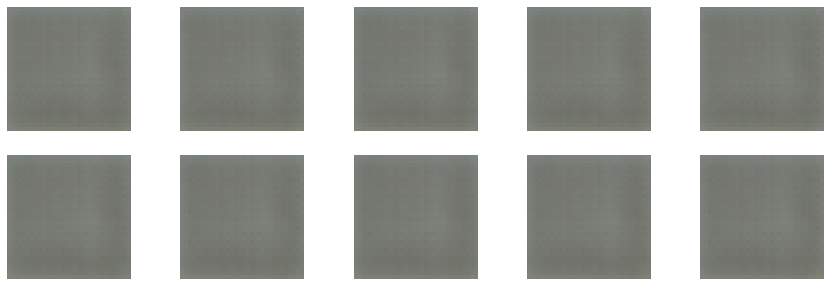

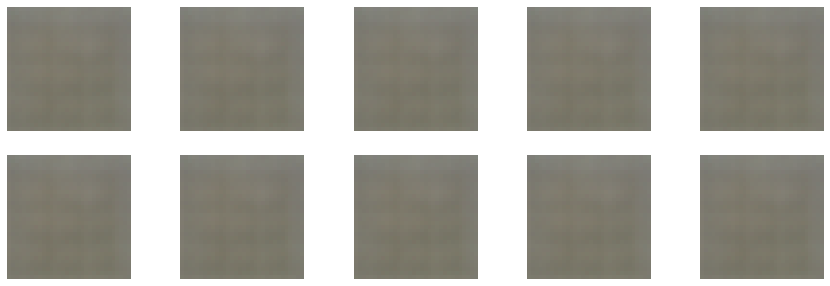

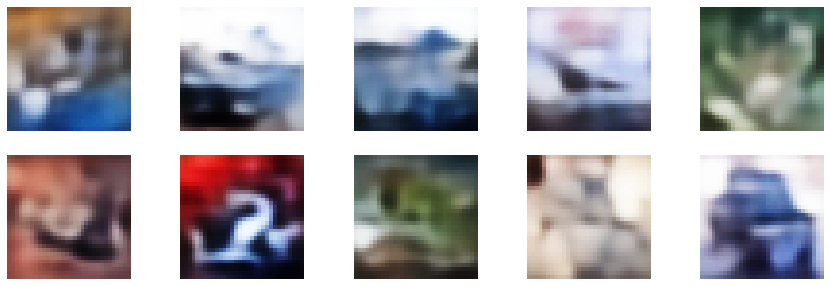

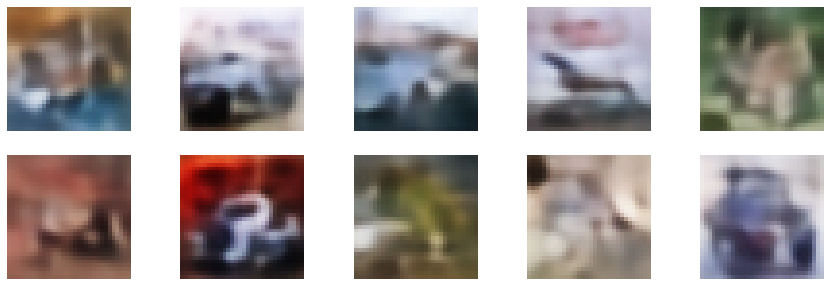

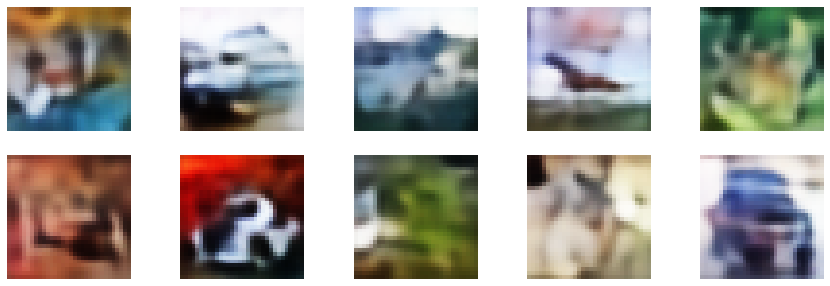

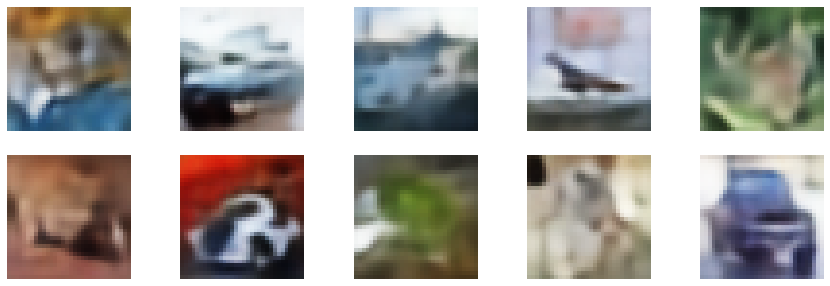

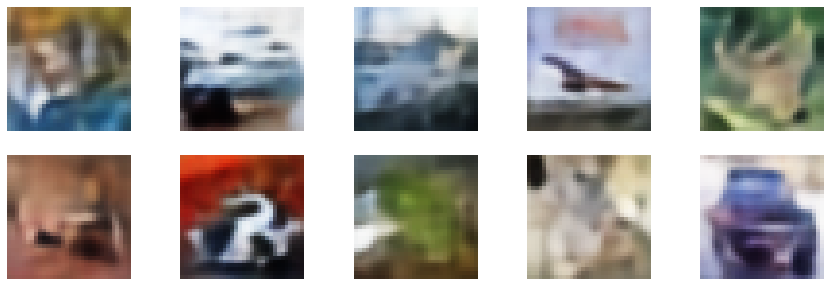

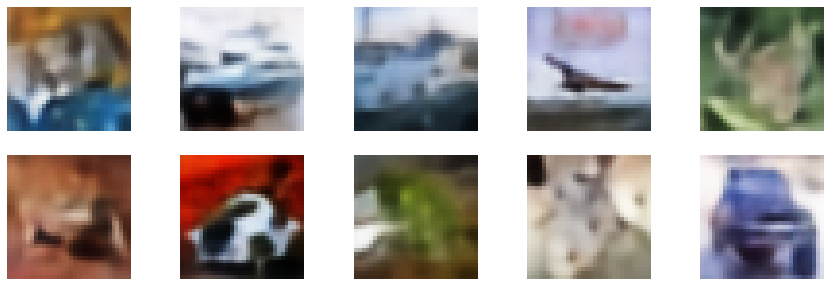

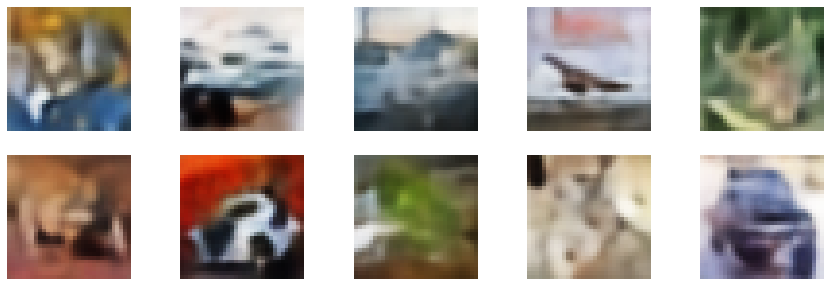

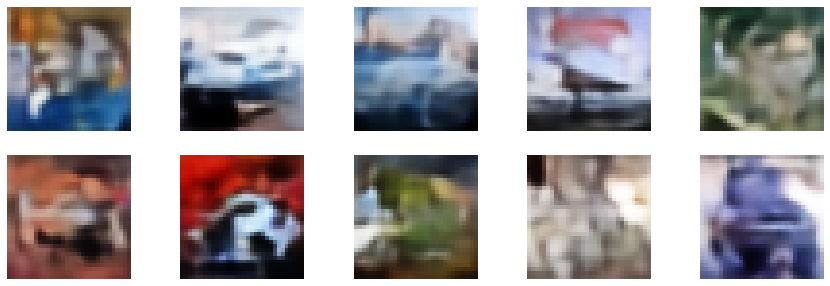

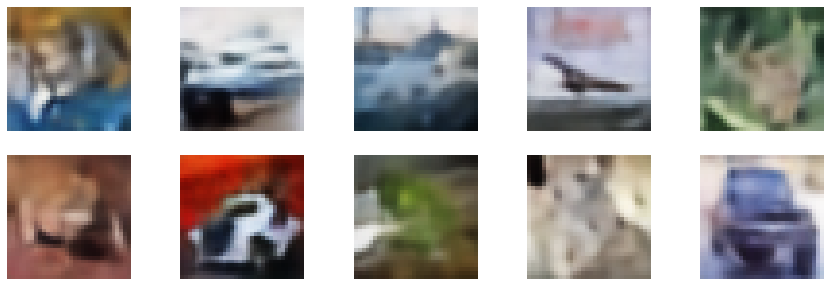

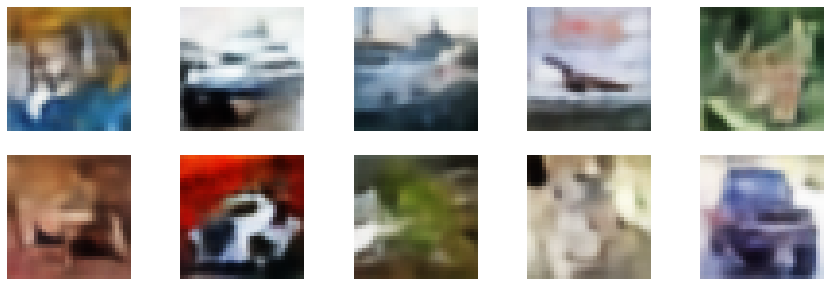

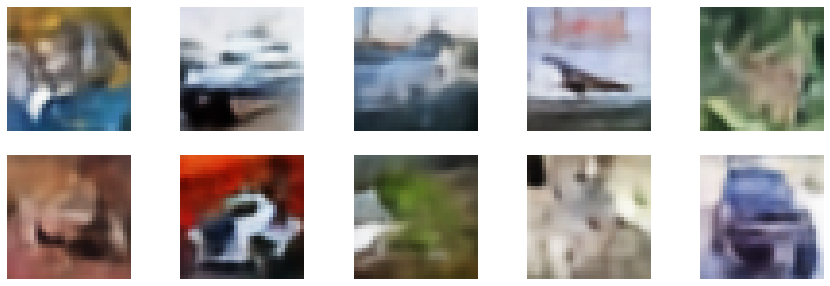

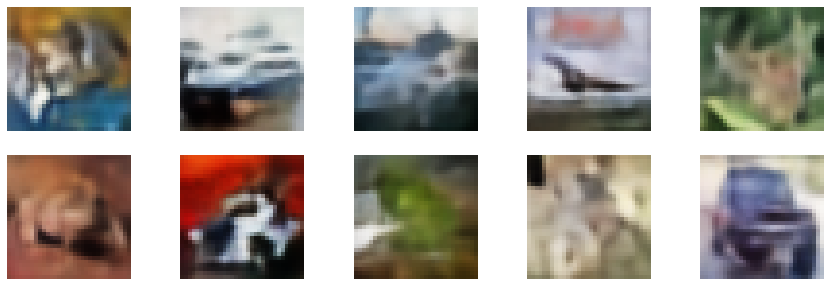

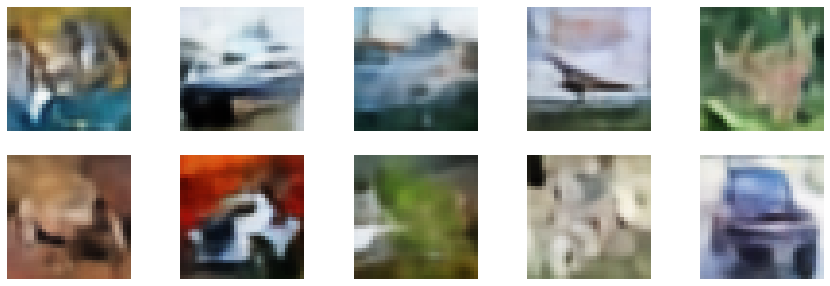

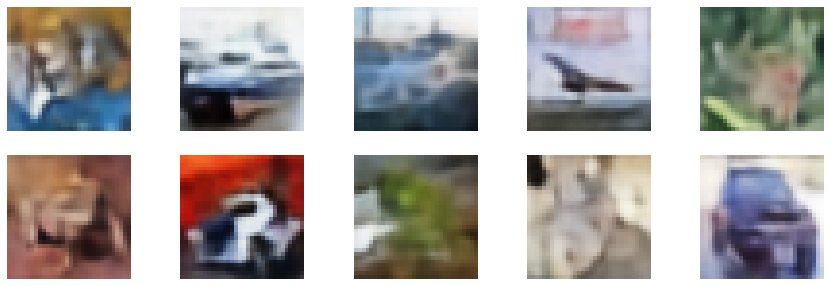

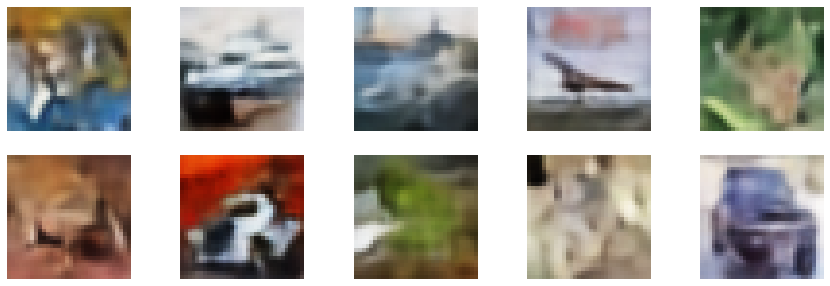

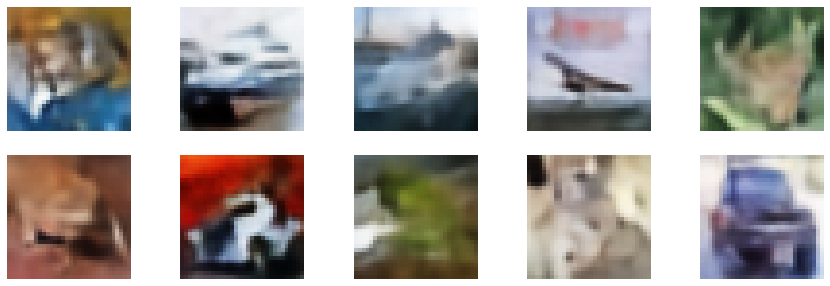

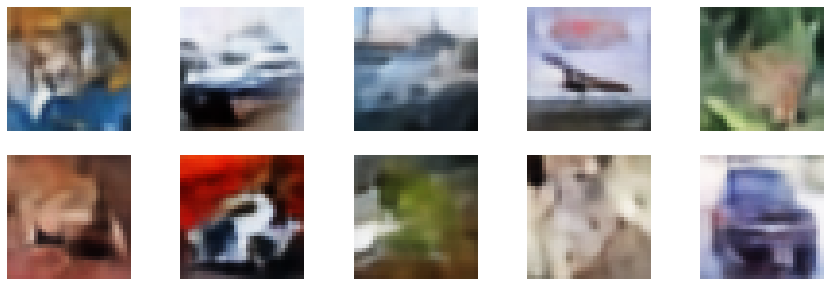

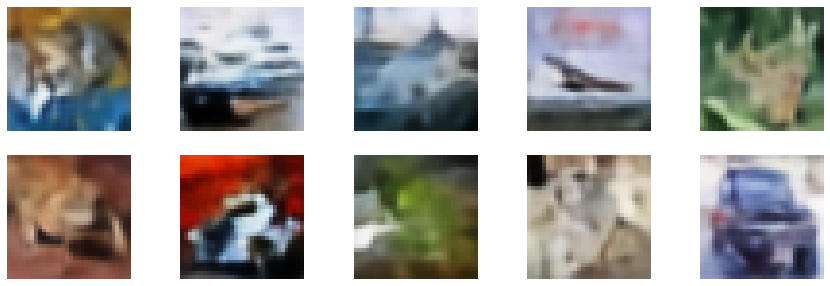

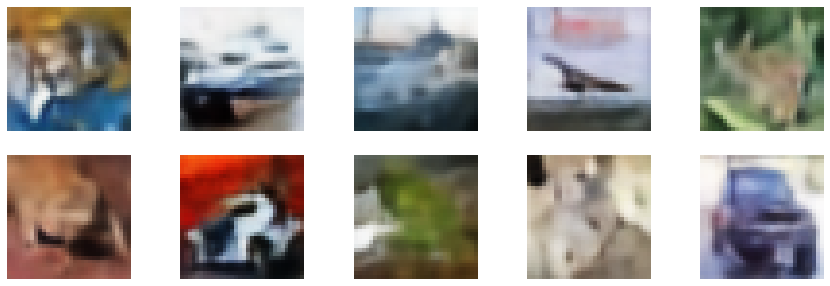

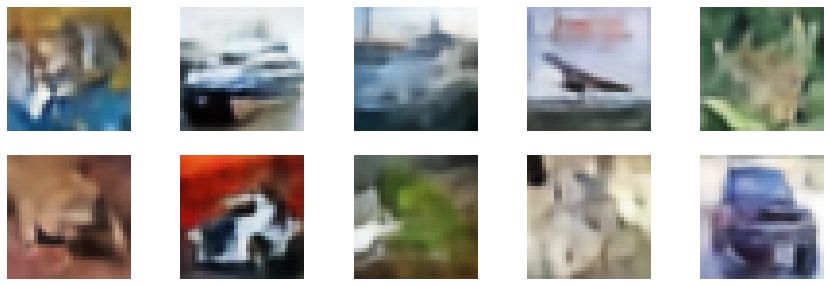

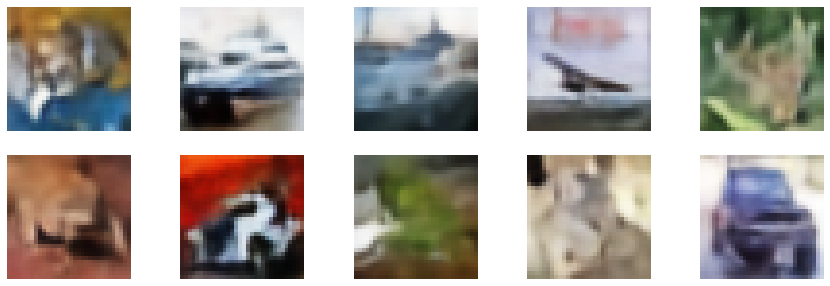

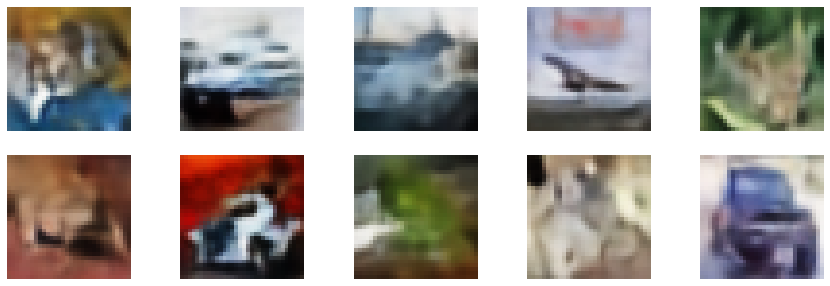

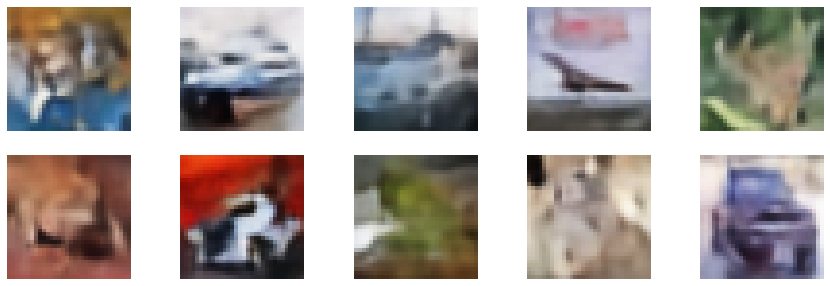

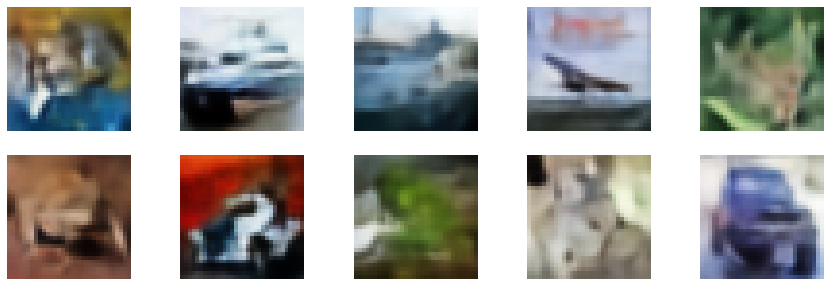

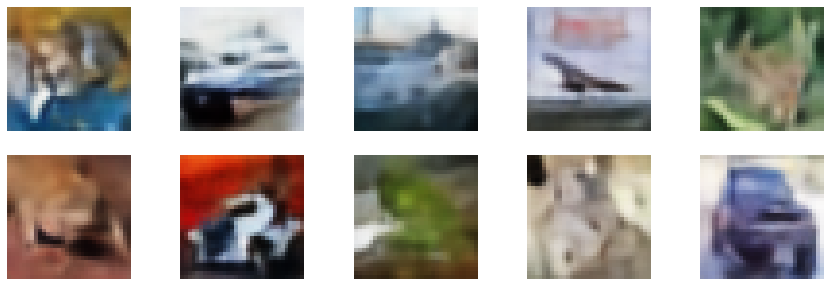

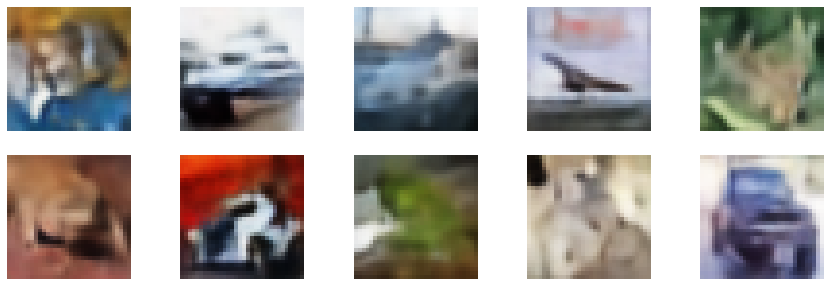

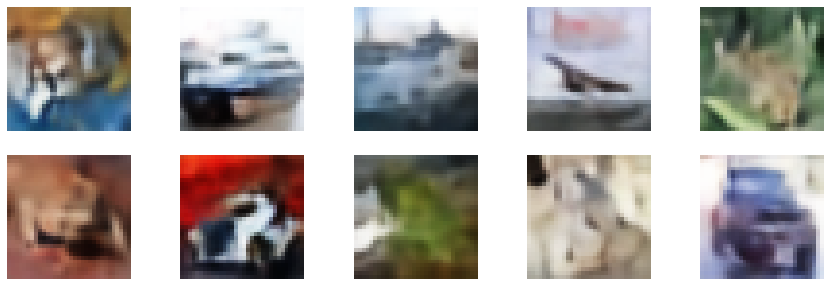

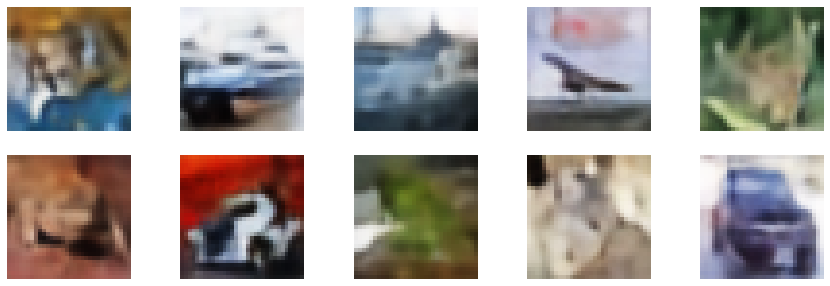

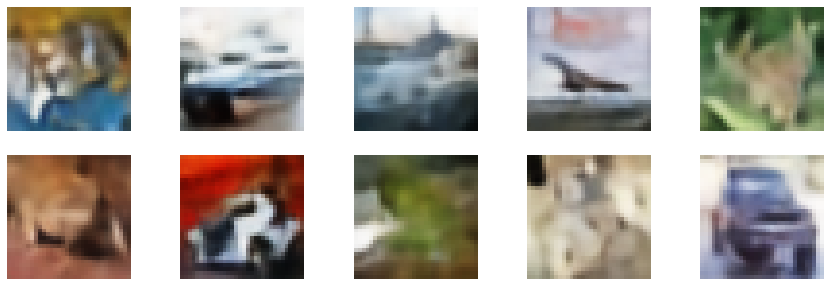

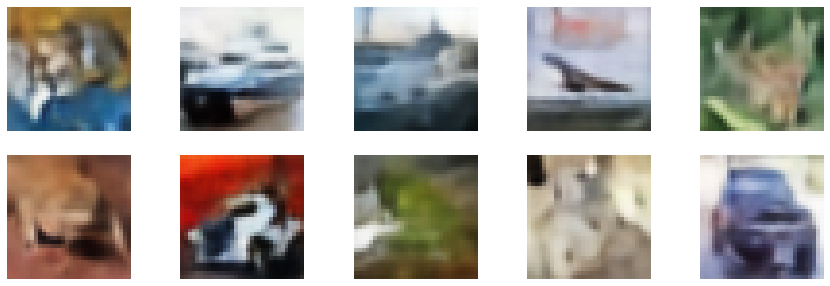

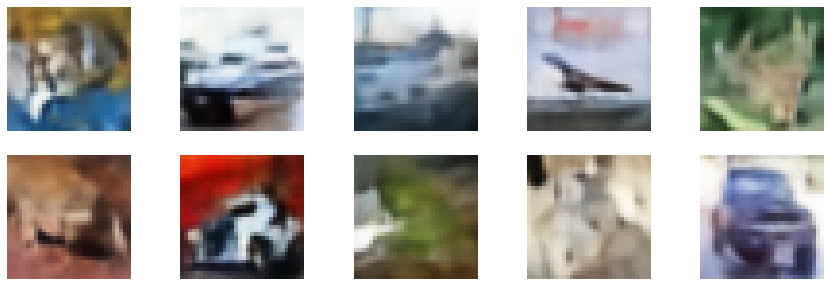

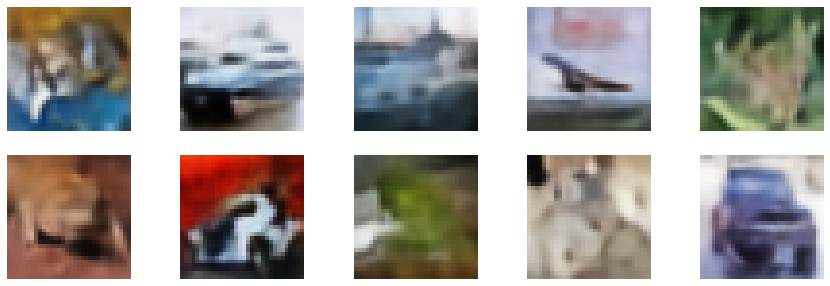

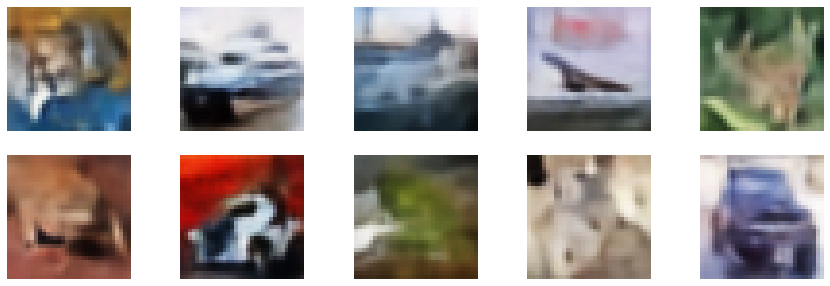

In [ ]:
minidc_dims=np.array([[30,30],[30,30]])

base_lr = 0.001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 350

latent_dim = 256
alpha_leaky = 0.2
filters = [64,128,256,512]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [1000,300]
discriminator_units = [200, 200]
keep_prob = 0.5
gen_coef = 2.

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size, gen_coef)
ae_loss_history, dc_loss_history, gen_loss_history = aae.fit(train_dataset, epochs=epochs, data_visual=test_images[:10])

Text(0, 0.5, 'BinCE')

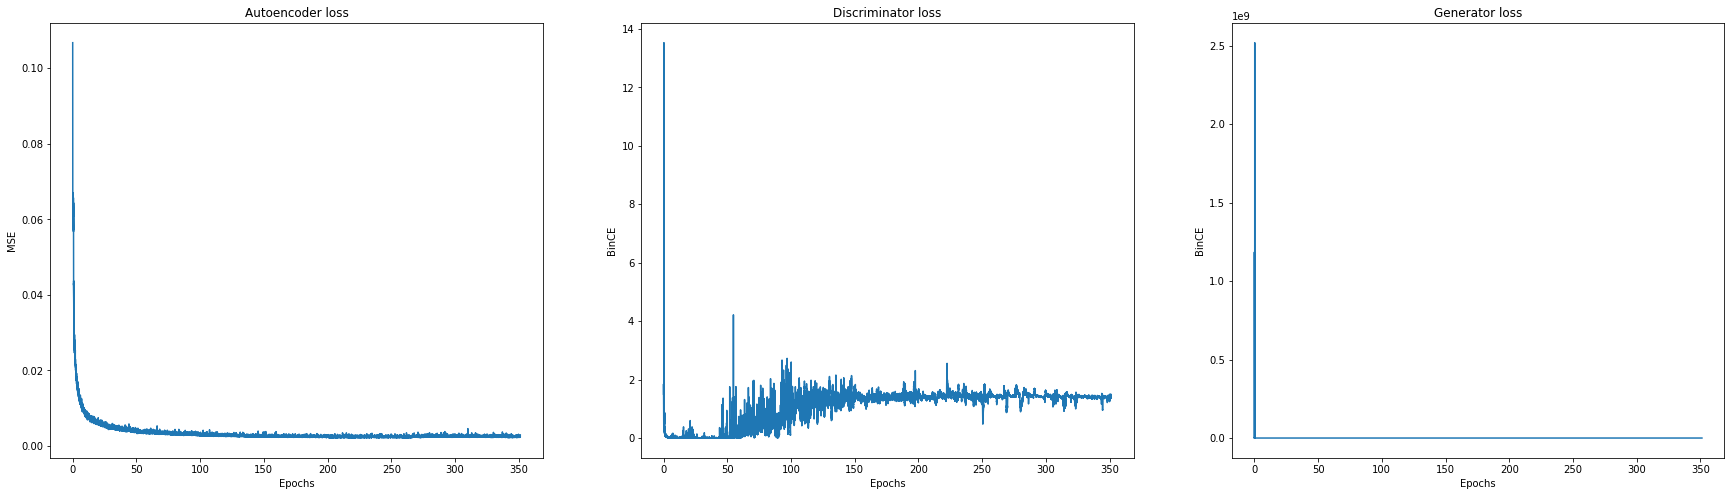

In [ ]:
steps_per_epoch = train_images.shape[0] / batch_size

F, ax = plt.subplots(1,3,figsize=(30,8))
ax[0].plot((np.arange(len(ae_loss_history))+1)/steps_per_epoch, ae_loss_history)
ax[0].set_title('Autoencoder loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE')
ax[1].plot((np.arange(len(dc_loss_history))+1)/steps_per_epoch, dc_loss_history)
ax[1].set_title('Discriminator loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('BinCE')
ax[2].plot((np.arange(len(gen_loss_history))+1)/steps_per_epoch, gen_loss_history)
ax[2].set_title('Generator loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('BinCE')


In [ ]:
aae.encoder.save('enc_model')
aae.decoder.save('dec_model')
aae.discriminator.save('dc_model')

2022-02-20 16:10:01.512665: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: enc_model/assets


INFO:tensorflow:Assets written to: dec_model/assets


INFO:tensorflow:Assets written to: dc_model/assets


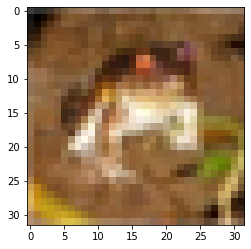

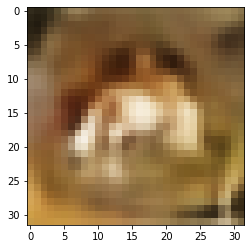

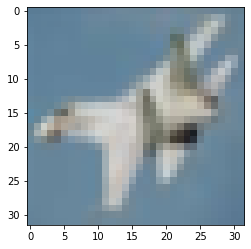

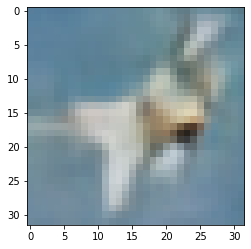

In [ ]:
image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

image = test_images[10,:,:,:].reshape((1,32,32,3))
z = aae.encode(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()


In [ ]:
# Faccio il test error per batch perché sul mio PC la GPU va OOM
test_errors = []
for x_batch in test_dataset:
    test_err = aae.autoencoder_loss(x_batch)
    test_errors.append(test_err)
test_err = np.mean(test_errors)
print(test_err)

0.004085294


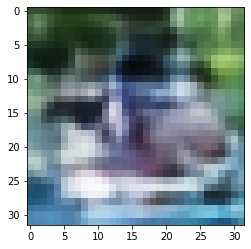

tf.Tensor([[-0.23142989]], shape=(1, 1), dtype=float32)


In [ ]:
z = np.random.randn(1,latent_dim)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
print(aae.discriminator(z))

In [ ]:
X = train_images[128].reshape((1,32,32,3))
z = aae.encode(X)
print(z)
vote = aae.discriminator(z)
print(vote)

tf.Tensor(
[[ 8.08882892e-01 -4.87012893e-01 -5.66076219e-01 -1.26819289e+00
   4.98222977e-01  9.60599065e-01  5.09393036e-01  1.48347163e+00
   1.41948938e+00  1.28639507e+00 -1.76753234e-02  1.63020301e+00
  -2.69565344e-01 -4.81382340e-01 -3.92662168e-01 -4.01407406e-02
   5.69336891e-01  3.21982414e-01  6.58347785e-01  3.41357857e-01
  -1.63545942e+00  4.49794412e-01 -2.45383000e+00 -1.24101925e+00
   1.19403875e+00 -6.32496178e-02 -7.03038424e-02 -1.49511361e+00
   9.02788103e-01 -8.75076115e-01 -5.87811291e-01  2.55535930e-01
   3.99530441e-01  1.13180444e-01  5.72386920e-01  3.20134699e-01
   2.72298843e-01 -1.55017209e+00  8.23402882e-01  9.62955236e-01
  -8.94265175e-01  7.82842934e-02 -2.47199774e-01  7.51543224e-01
  -6.94947541e-01 -6.48851156e-01  1.09139574e+00  2.38714233e-01
   5.45301259e-01 -4.61425036e-01  9.95204508e-01 -1.23148169e-02
  -9.32049751e-01  1.63254213e+00  5.21469582e-03 -1.16319591e-02
  -4.30979013e-01 -2.39523649e-01  5.61913103e-02 -3.88286114e-01